## <u>Tabel Of Content</u>
* [1. DataFrame](#df) 
* [2. DataLoader](#loader)
    * [2. Custom Dataset and Trasformers](#loader1)
    * [2. DataLoader Assistent Function](#loader2)
* [3. Vizualization](#viz) 
* [4. Metrics and Losses](#met)
    * [4.1 Focal Loss](#met1)
    * [4.2 Binaray metrics and accuracy](#met2)
    * [4.3 Multilabel Metrices](#met3)
    * [4.4 Per Class/Bin Metrices](#met4)
* [5. Models](#models)
    * [5. AutoEncoder](#models1)
    * [5. Unet Autoencoder](#models2)
    * [5. Three head Classification Model](#models3)
    * [5. Three head Detector Model](#models4)
* [6. Trainers](#tr)
    * [6.1 Detector Trainer](#dtr)
    * [6.2 Unet Trainer](#utr)
    * [6.3 Multilabel Trainer](#mltr)
    * [6.4 Misc](#misc)
    * [6.5 Plots](#plot)
* [7. Training](#train)
    * [7.1 Multilabel Trainer](#train1)
    * [7.2 UNET Trainer](#train2) 
    * [7.3 UNET multilabel Trainer](#mlutr) 
    * [7.4 Detector](#detect) 
        * [7.4.1 Detector without normalization](#detect1) 
        * [7.4.2 Detector with normalization](#detect2)
        * [7.4.2 Detector with BCE](#detect3)
        * [7.4.2 Detector with BCE combine F1](#detect4)
* [8. ML decoder](#mld)
* [8. Ensemble ANN](#ensemble)

# ML-Decoder will be more usefull in the Multilable classification.

In [2]:
import torchvision.models as Models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from skimage import io, transform
import os
import torch.nn as nn
import torch.nn.functional as F
import copy

In [3]:
!pip install -r /kaggle/working/requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.3/137.3 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for inplace-abn: filename=inplace_abn-1.1.0-cp310-cp310-linux_x86_64.whl size=474602 sha256=e3b57bef5e0f7ffa37de07d69e5e4c7996664852f4a9ad048b5535b9c0234470
  Stored in directory: /root/.cache/pip/wheels/c7/f2/05/97ab74dbf2ed6d592684f76d0ae8f33f66bbafa0ec5b53b416
  Created wheel for pycocotools: filename=pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl size=101741 sha256=3d31b4e3a6edb3a13fd24ed1c960f6563cb7a2724a9373616a0795044c56fd63
  Stored in directory: /root/.cache/pip/wheels/58/e6/f9/f87c8f8be098b51b616871315318329cae12cdb618f4caac93
Successfully built inplace-abn pycocotools


In [4]:
# ! pip install torcheval

# 1. DataFrames  <a class="anchor"  id="df"></a>

In [5]:
original=pd.read_csv("/kaggle/input/rfmid30/RFMiD2.0/Training_set/Cleaned_train_split_extended.csv")
traindf=pd.read_csv("/kaggle/input/rumed-data/MuReD/train_data.csv")
valdf=pd.read_csv("/kaggle/input/rumed-data/MuReD/val_data.csv")
testdf=pd.read_csv("/kaggle/input/rfmid30/RFMiD2.0/Test_set/Cleand_test_data_final.csv")

In [6]:
traindf

,ID,DR,NORMAL,MH,ODC,TSLN,ARMD,DN,MYA,BRVO,...,CRVO,CNV,RS,ODE,LS,CSR,HTR,ASR,CRS,OTHER
0,aria_c_25_1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,aria_c_7_2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,aria_c_38_2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,aria_c_2_8,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,aria_c_26_15,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759,im0395,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1760,im0396,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1761,im0398,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1762,im0400,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [7]:
traindf[traindf["NORMAL"]==1].sum()

ID        aria_c_25_1aria_c_7_2aria_c_38_2aria_c_2_8aria...
DR                                                        0
NORMAL                                                  395
MH                                                        0
ODC                                                       0
TSLN                                                      0
ARMD                                                      0
DN                                                        0
MYA                                                       0
BRVO                                                      0
ODP                                                       0
CRVO                                                      0
CNV                                                       0
RS                                                        0
ODE                                                       0
LS                                                        0
CSR                                     

In [8]:
traindf[(traindf["NORMAL"]==1) & (traindf["OTHER"]==1)]

,ID,DR,NORMAL,MH,ODC,TSLN,ARMD,DN,MYA,BRVO,...,CRVO,CNV,RS,ODE,LS,CSR,HTR,ASR,CRS,OTHER
1639,im0213,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [9]:
traindf=traindf[traindf["ID"]!="im0213"]
traindf

,ID,DR,NORMAL,MH,ODC,TSLN,ARMD,DN,MYA,BRVO,...,CRVO,CNV,RS,ODE,LS,CSR,HTR,ASR,CRS,OTHER
0,aria_c_25_1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,aria_c_7_2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,aria_c_38_2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,aria_c_2_8,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,aria_c_26_15,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759,im0395,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1760,im0396,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1761,im0398,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1762,im0400,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


/tmp/ipykernel_28/1926136357.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(traindf.corr()[traindf.corr()>0.15])


<Axes: >

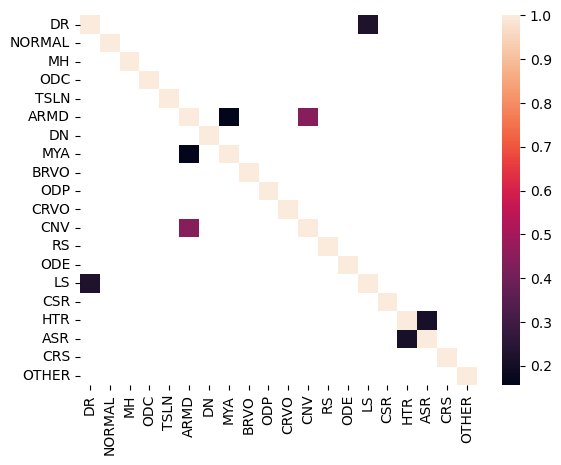

In [10]:
import seaborn as sns
sns.heatmap(traindf.corr()[traindf.corr()>0.15])

In [11]:
valdf

,ID,DR,NORMAL,MH,ODC,TSLN,ARMD,DN,MYA,BRVO,...,CRVO,CNV,RS,ODE,LS,CSR,HTR,ASR,CRS,OTHER
0,aria_c_28_19,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,aria_c_36_4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,aria_c_40_b_14,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,aria_c_23_23,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,aria_c_43_1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,im0373,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
440,im0377,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
441,im0397,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
442,im0399,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [12]:
testdf

,ID,WNL,ARMD,BRVO,CME,CRS,CRVO,CSR,CWS,DN,...,MH,MS,MYA,ODC,ODE,ODP,RS,RT,TSLN,RareDisease
0,189,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,201,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,216,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,220,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,228,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,896,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
146,897,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
147,898,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
148,899,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
original

,ID,WNL,AH,AION,ARMD,BRVO,CB,CF,CL,CME,...,RS,RT,SOFE,ST,TD,TSLN,TV,VS,HTN,IIH
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178,21916,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2179,21917,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2180,21918,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2181,21919,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# traindf[traindf["WNL"]==0].drop(columns=["ID","WNL"]).sum().plot(kind="bar")

In [15]:
# C=C.values

# 2. DataLoader  <a class="anchor"  id="loader"></a>

## 2.1 Custom Dataset and Trasformers <a class="anchor"  id="loader1"></a>

In [16]:
from PIL import Image
class Df_to_Dataset(torch.utils.data.Dataset):
    def __init__(self,df:pd.DataFrame,img_dir:str,start,end=None,Transform=None):
        self.data=df
        self.dir=img_dir
        self.transform=Transform
        self.start=start
        self.end= end
        
    def __len__(self):
        return(self.data.shape[0])
    
    def __getitem__(self,index):
        if torch.is_tensor(index):
            index = index.tolist()

        img_path = os.path.join(self.dir,str(self.data.iloc[index, 0])+".png")
        image = Image.open(img_path)
        if self.end!=None:
            labels = self.data.iloc[index,self.start:self.end]
        else:
            labels = self.data.iloc[index,self.start:]
        labels = labels.to_numpy().astype("float")
        if self.transform:
            image = self.transform(image)
        output = (image, labels)
        return output
    
    
class normalize(object):
    def __call__(self,sample):
        image=sample
# #         print(image.shape)
#         mean=torch.cat(imgs,dim=1).mean(dim=[0,2,3])
#         std=torch.cat(imgs,dim=1).std(dim=[0,2,3])
#         image=transforms.Normalize(mean=mean,std=std)(image)
# #         print(mean,std)
        image=transforms.Resize(512, antialias=True)(image)
#         image=transforms.functional.center_crop(image,512)
#         image=transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])(image)
#         image=transforms.Resize(384)(normal(image))
        return image
    
    
class augmentate(object):
    def __init__(self,hue=0,saturation=0):
        self.saturation=saturation
        self.hue=hue
        
        
    def __call__(self,sample):
        image=sample
        image=transforms.RandomRotation([-30,30])(image)
#         image=transforms.RandomAdjustSharpness(1.7)(image)
        image=transforms.ColorJitter(brightness=0.1,contrast=0.1,saturation=self.saturation,hue=self.hue)(image)
        image=transforms.RandomVerticalFlip(0.5)(image)
        image=transforms.RandomHorizontalFlip(0.5)(image)
        return image
    
    
class ToTensor(object):
    def __call__(self,sample):
        image=np.asarray(sample)
        image=image.transpose((2,0,1))
        return torch.from_numpy(image).type(torch.FloatTensor)
    


In [17]:
# traindf=traindf.query("ID in @origin")

## 2.2 DataLoader Assistent Function <a class="anchor"  id="loader2"></a>

In [18]:
from torch.utils.data import DataLoader
from torchvision import transforms
batch_size=16
train_ds=train_data=val_ds=val_data=test_ds=test_data="null"

def setdata(i,x=None,j=None,worker=2,prefetch=None):
    global train_ds,train_data,val_ds,val_data,test_ds,test_data,batch_size
    train_ds=Df_to_Dataset(traindf,"/kaggle/input/rumed-data/MuReD/Data/",i,j, Transform=transforms.Compose([augmentate(saturation=0),transforms.ToTensor()]))#transforms.Compose([augmentate(),ToTensor(),normalize()]))
    train_data=DataLoader(train_ds,batch_size,True,num_workers=worker,prefetch_factor=prefetch,pin_memory=True)
    val_ds=Df_to_Dataset(valdf,"/kaggle/input/rumed-data/MuReD/Data/",i,j, Transform=transforms.Compose([transforms.ToTensor()]))
    val_data=DataLoader(val_ds,batch_size,False,num_workers=worker)
    test_ds=Df_to_Dataset(testdf,"/kaggle/input/rfmid30/RFMiD2.0/Test_set/3/",i,j,Transform=transforms.Compose([ToTensor(),normalize()]))
    test_data=DataLoader(test_ds,16,True,num_workers=2)

In [19]:
setdata(1)

In [20]:
train_ds[1][1] #validated

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [21]:
len(train_ds)

1763

In [22]:
val_ds[1][1]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

# 3. Visualization  <a class="anchor"  id="viz"></a>

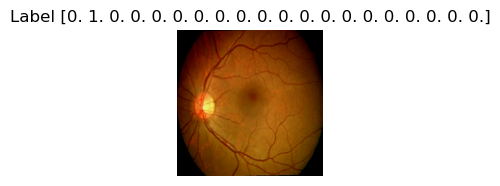

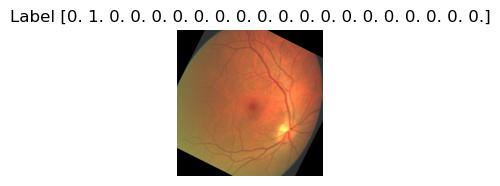

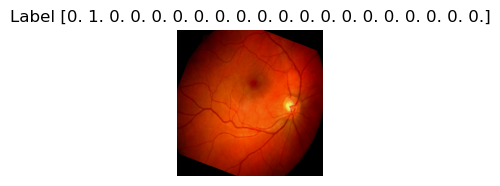

In [23]:
def plotimage(ds,index):
    g=0
    fig=plt.figure()
    for i in index:
        ax=plt.subplot(1,len(index),g+1)
#         plt.tight_layout()
        ax.axis("off")
        img=transforms.ToPILImage()(ds[i][0])#np.transpose(ds[i][0].cpu().detach().numpy(),(1,2,0))
#         mean = np.array([0.485, 0.456, 0.406])
#         std = np.array([0.229, 0.224, 0.225])
#         img = std * img + mean
        plt.imshow(img)#.astype("uint8"))
        ax.set_title("Label {}".format(ds[i][1]))
        plt.pause(0.001)
        g+=1
        if g==4:
            break
    plt.show()

plotimage(train_ds,[1,2,3])

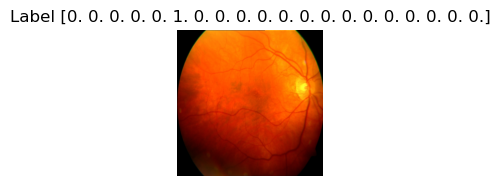

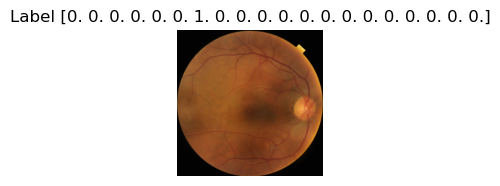

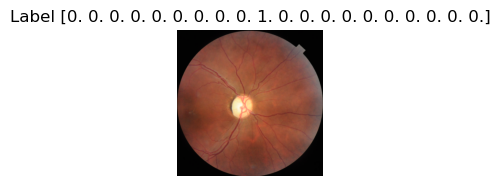

In [24]:
plotimage(val_ds,[15,50,73])

/tmp/ipykernel_28/3288207737.py:65: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  return torch.from_numpy(image).type(torch.FloatTensor)


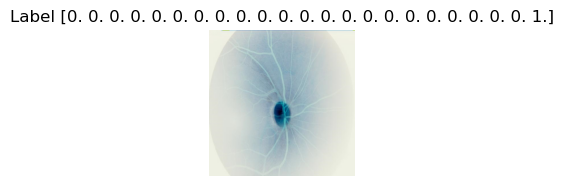

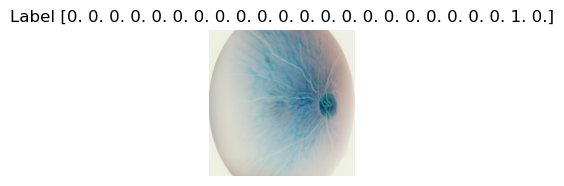

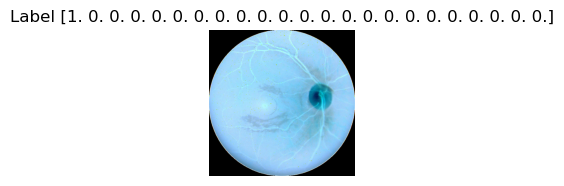

In [25]:
plotimage(test_ds,[2,55,120])

# 4. Metrices and Losses  <a class="anchor"  id="met"></a>

## 4.1 Focal Loss <a class="anchor"  id="met1"></a>

In [26]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):
        bce_loss = F.binary_cross_entropy_with_logits(input, target,reduction=self.reduction,pos_weight=self.weight)
        pt = torch.exp(-bce_loss)
        focal_loss = (((1 - pt) ** self.gamma )* bce_loss).mean()
        return focal_loss

In [27]:
# class FocalBCELoss(nn.modules.loss._WeightedLoss):
#     def __init__(self, weight=None, gamma=2,reduction='sum'):
#         super(FocalBCELoss, self).__init__(weight,reduction=reduction)
#         self.gamma = gamma
#         self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

#     def forward(self, inputt, target):
#         inputt=F.sigmoid(inputt).round()
#         inputt=torch.where(target >= 0.5, inputt, 1-inputt)
#         logp = - torch.log(torch.clamp(inputt, 1e-4, 1-1e-4))
#         loss = logp*((1-inputt)**self.gamma)
#         loss = (self.weight*loss).mean()
#         return loss
    

## 4.2 Binaray metrics and accuracy  <a class="anchor"  id="met2"></a>

In [28]:
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,classification_report,roc_curve,average_precision_score,hamming_loss,roc_auc_score
# from torcheval.metrics import MultilabelAccuracy,MultilabelAUPRC
def Accuracy(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / y_true.shape[0]


def acc(pred, true):
    pred=np.round(torch.cat(pred).detach().cpu().numpy())
    true=np.asarray(torch.cat(true).detach().cpu().numpy())
#     print(pred)
    return precision_score(true,pred,zero_division=0.0), f1_score(true,pred,zero_division=0.0), accuracy_score(true,pred), recall_score(true,pred)
# C=torch.reciprocal(torch.tensor(C).float())
# C

## 4.3 Multilabel Metrices  <a class="anchor"  id="met3"></a>

In [163]:
def Metrics(pred, true):
    pred=np.round(torch.cat(pred, dim=0).detach().cpu().numpy())
    true=np.asarray(torch.cat(true,dim=0).detach().cpu().numpy())
    print(pred.shape,true.shape)
    mAP=average_precision_score(true,pred, average="macro")
    AUC=roc_auc_score(true, pred, average='macro')
    return mAP, f1_score(true,pred,zero_division=0.0, average='macro'),AUC,(mAP+AUC)/2

def RFMID_Metrics(preds,label):
    f1=[]
    AP=[]
    AUC=[]
    binf1=0
    binap=0
    binauc=0
    for i in range(label.shape[1]):
        if i!=1:
            f1.append(f1_score(label[:][i],preds[:][i]))
            AP.append(average_precision_score(label[:][i],preds[:][i]))
            AUC.append(roc_auc_score(label[:][i],preds[:][i]))
        else:
            binf1=f1_score(label[:][i],preds[:][i])
            binap=average_precision_score(label[:][i],preds[:][i])
            binauc=roc_auc_score(label[:][i],preds[:][i])
    modelscore=(np.mean(AP)+np.mean(AUC))/2
    return np.mean(f1), np.mean(AP), np.mean(AUC), modelscore, binf1, binap, binauc, (modelscore+binauc)/2
    

## 4.4 Per Class/Bin Metrices  <a class="anchor"  id="met4"></a>

In [164]:
def binmetrics(df,model):
    data=torch.utils.data.DataLoader(
        df, batch_size=16, shuffle=False,
        num_workers = 2, pin_memory=False)
    model.eval()
    preds=[]
    label=[]
    with torch.no_grad():
        for img,lbl in data:
            model=model.cuda()
            img=img.to("cuda:0")
            preds.append(F.sigmoid(model(img)))
            label.append(lbl)
    try:
         print(' \n==>> Test set: mAP: ({:.5f})  AUC: ({:.5f})  F1:({:.5f}) ModelScore:({:.5f})\n'.format(
                Metrics(pred,true)))
    except:
         pass
    preds=np.round(torch.cat(preds,dim=0).detach().cpu().numpy())
    label=np.asarray(torch.cat(label,dim=0).detach().cpu().numpy())
    if preds.shape[1]==1:
        print(classification_report(label,preds))
    else:
        print("Lable\t\tPrec\t\tRecall\t\tF1\t\tAUC")
        for i,j in enumerate(df.data.drop(columns="ID").columns):
            print("{}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}".format(j,precision_score(label[:][i],preds[:][i]), recall_score(label[:][i],preds[:][i]),f1_score(label[:][i],preds[:][i]),roc_auc_score(label[:][i],preds[:][i])))
        print("\n ML_F1:({:.3f}) ML_mAP:({:.3f}) ML_AUC:({:.3f}) ML_Score:({:.3f}) Bin_F1:({:.3f}) Bin_mAP:({:.3f}) Bin_AUC:({:.3f}) ModelScore:({:.3f})".format(*RFMID_Metrics(preds,label)))

# 5. Models  <a class="anchor"  id="models"></a>

## 5.1 Auto encoder  <a class="anchor"  id="models1"></a>

In [31]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x
    
    

class encoder_ae_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return p
    
    

class decoder_ae_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c, out_c)
    
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = self.conv(x)
        return x

    
    
class unet(nn.Module):
    def __init__(self):
        super().__init__()
#          """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
#          """ Bottleneck """
        self.b = conv_block(512, 1024)
#          """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
#          """ Classifier """
        self.outputs = nn.Conv2d(64, 3, kernel_size=1, padding=0)
    
    def forward(self, inputs):
#         """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
#          """ Bottleneck """
        b = self.b(p4)
#          """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
#          """ Classifier """
        outputs = self.outputs(d4)
        return outputs

## 5.2 UNet 3 channel  <a class="anchor"  id="models2"></a>

In [32]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
    
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x
    
    

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p
    
    

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

    
    
class unet(nn.Module):
    def __init__(self):
        super().__init__()
#          """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
#          """ Bottleneck """
        self.b = conv_block(512, 1024)
#          """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
#          """ Classifier """
        self.outputs = nn.Conv2d(64, 3, kernel_size=1, padding=0)
    
    def forward(self, inputs):
#         """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
#          """ Bottleneck """
        b = self.b(p4)
#          """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
#          """ Classifier """
        outputs = self.outputs(d4)
        return outputs

## 5.3 Three headed Classification model <a class="anchor"  id="models3"></a>

In [33]:
class Classifier_model2(nn.Module):
    def __init__(self,number_out,dropout=0.2):
        super(Classifier_model2,self).__init__()
        self.Conv1=nn.C
        self.Linear1=nn.Linear(512*3,512)
        self.Linear2=nn.Linear(512,512)
        self.dropout=nn.Dropout(p=dropout,inplace=True)
        self.output=nn.Linear(512,number_out)
        self.Resize=transforms.Resize
        
    def forward(self,x):
        x1=self.effnetv2(self.Resize((384,384),antialias=True)(x))
        x2=self.covnext(self.Resize((224,224),antialias=True)(x))
        x3=self.effnetb4(self.Resize((380,380),antialias=True)(x))
        x=torch.cat([x1,x2,x3],dim=1)
        x=self.Linear1(x)
        x=self.Linear2(x)
        x=self.dropout(x)
        out=self.output(x)
        return out
        

In [34]:
class Classifier_model(nn.Module):
    def __init__(self,number_out,dropout=0.2):
        super(Classifier_model,self).__init__()
        self.effnetv2=Models.efficientnet_v2_s(weights="DEFAULT")
        self.covnext=Models.convnext_tiny(weights="DEFAULT")
        self.effnetb4=Models.efficientnet_b4(weights="DEFAULT")
        for model in [self.effnetv2,self.covnext,self.effnetb4]:    
            for param in model.parameters():
                param.requires_grad = False
        self.effnetv2.classifier[1]=nn.Linear(1280,512)
        self.effnetb4.classifier[1]=nn.Linear(1792,512)
        self.covnext.classifier[2]=nn.Linear(768,512)
        self.Linear1=nn.Linear(512*3,512)
        self.Linear2=nn.Linear(512,512)
        self.dropout=nn.Dropout(p=dropout,inplace=True)
        self.output=nn.Linear(512,number_out)
        self.Resize=transforms.Resize
        
    def forward(self,x):
        x1=self.effnetv2(self.Resize((384,384),antialias=True)(x))
        x2=self.covnext(self.Resize((224,224),antialias=True)(x))
        x3=self.effnetb4(self.Resize((380,380),antialias=True)(x))
        x=torch.cat([x1,x2,x3],dim=1)
        x=self.Linear1(x)
        x=self.Linear2(x)
        x=self.dropout(x)
        out=self.output(x)
        return out
        

## 5.4 Three Headed Detector Models  <a class="anchor"  id="models4"></a>

In [35]:
class Detector_model(nn.Module):
    def __init__(self,dropout=0.2):
        super(Detector_model,self).__init__()
        self.effnetv2=Models.efficientnet_v2_s(weights="DEFAULT")
        self.covnext=Models.convnext_tiny(weights="DEFAULT")
        self.effnetb4=Models.efficientnet_b4(weights="DEFAULT")
        for model in [self.effnetv2,self.covnext,self.effnetb4]:    
            for param in model.parameters():
                param.requires_grad = False
        self.effnetv2.classifier[1]=nn.Linear(1280,512)
        self.effnetb4.classifier[1]=nn.Linear(1792,512)
        self.covnext.classifier[2]=nn.Linear(768,512)
        self.Linear1=nn.Linear(512*3,512)
        self.dropout=nn.Dropout(p=dropout,inplace=True)
        self.output=nn.Linear(512,1)
        self.Resize=transforms.Resize
        
    def forward(self,x):
        x=[transforms.RandomCrop((400,400))(x) for i in range(3)]
        x1=self.effnetv2(self.Resize((384,384),antialias=True)(x[0]))
        x2=self.covnext(self.Resize((224,224),antialias=True)(x[1]))
        x3=self.effnetb4(self.Resize((380,380),antialias=True)(x[2]))
        x=torch.cat([x1,x2,x3],dim=1)
        x=self.Linear1(x)
        x=self.dropout(x)
        out=self.output(x)
        return out
        

# 6. Trainers  <a class="anchor"  id="tr"></a>

## 6.1 The Detector Trainer <a class="anchor"  id="dtr"></a>

In [36]:
import torchvision
from torch.cuda.amp import GradScaler, autocast
# import torcheval.metrics from Bi
def Tranfertrainloop_detector(config,n_epochs=10,Step_factor=2,epoch_print_gap=1,modelin=None,focal=False):
    try:
        if modelin==None:
            model=Detector_model(0.2)
        else:
            model=modelin

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
            if torch.cuda.device_count() > 1:
                model = nn.DataParallel(model)        
        model = model.to(device)
        
#losss and optimizer
        optimizer=torch.optim.Adam(model.parameters(),lr=config["lr"])
        scheduler=torch.optim.lr_scheduler.StepLR(optimizer, n_epochs//2)
        scaler=GradScaler()
#         loss_fn=FocalLoss(weight=C.to(device))
        if focal:
            loss_fn=torchvision.ops.sigmoid_focal_loss
        else:
            loss_fn=torch.nn.BCEWithLogitsLoss()
#             loss_fn=FocalLoss(reduction="sum")
        history={"train":{"loss":[],"precision":[],"f1":[],"accuracy":[],"recall":[]},"test":{"loss":[],"precision":[],"f1":[],"accuracy":[],"recall":[]}}
        best_f1=None
        best_weights=copy.deepcopy(model.state_dict())
        for epoch in range(1, n_epochs + 1):
            printer=""
            loss_train = 0.0
            accuracy=[]
            true=[]
            test_loss = 0
            correct = []
            model.train()
            for imgs,labels in train_data:
#                 true+=1
                optimizer.zero_grad()
                imgs=imgs.to(device)
#                 imgs=preprocess(imgs)
                with autocast():
                    outputs = model(imgs).float()
#                 model.zero_grad()
                labels=labels.to(device)
                loss = loss_fn(outputs, labels)
                scaler.scale(loss.sum()).backward() # loss.backward()
                scaler.step(optimizer)
                scaler.update()
                loss_train += loss.mean().item()
                pred_train = F.sigmoid(outputs)
                pred_train=pred_train.to(device)#.argmax(dim=1,keepdim=True)  # get the index of the max log-probability
                accuracy.append(pred_train)
                true.append(labels)
            
            prec,f1,a,r=acc(accuracy,true)
            loss_train=(loss_train/(len(train_data.dataset)//batch_size))
            history["train"]["loss"].append(loss_train)
            history["train"]["precision"].append(prec)
            history["train"]["f1"].append(f1)
            history["train"]["accuracy"].append(a)
            history["train"]["recall"].append(r)
            printer+='Epoch {}, \nTraining set: loss {:.7f} Precision: ({:.5f}%)  F1: ({:.5f}) Accuracy: ({:.5f}%) Recall: ({:.5f}%)'.format(epoch, float(loss_train),prec*100,f1,a*100,r*100)
            
            model.eval()
            with torch.no_grad():
                pred=[]
                for data,target in val_data:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    target=target.type(torch.FloatTensor).to(device)
                    test_loss += loss_fn(output, target).mean().item()  # sum of mean batch loss
#                     pred=F.sigmoid(output).to(device) #.argmax(dim=1,keepdim=True)  # get the index of the max log-probability
                    pred.append(F.sigmoid(output))
                    correct.append(target)
        #prec and f1
                test_prec,test_f1,ta,tr=acc(pred,correct)
                test_loss=(test_loss/(len(val_data.dataset)//batch_size))
                
                printer+=' \n==>> Test set: loss {:.7f} Precision: ({:.5f}%)  F1: ({:.5f}) Accuracy: ({:.5f}%) Recall: ({:.5f}%)\n'.format(
                test_loss,
                test_prec*100,test_f1,ta*100,tr*100)
                
                history["test"]["loss"].append(test_loss)
                history["test"]["precision"].append(test_prec)
                history["test"]["f1"].append(test_f1)
                history["test"]["accuracy"].append(ta)
                history["test"]["recall"].append(tr)
                if epoch == 1 or epoch % epoch_print_gap == 0:
                    print(printer)
                if (best_f1==None or test_loss<=best_f1):
                    print("__")
                    best_f1=test_loss
                    best_weights=copy.deepcopy(model.state_dict())
            scheduler.step()
        model.load_state_dict(best_weights)
        return model,history
        print("Finished Training")
    except:
        del model
        del optimizer
        del loss
        Exception.with_traceback()

## 6.2 UNET trainer <a class="anchor"  id="utr"></a>

In [37]:
import torchvision
def TranfertrainloopUNET(config,n_epochs=10,epoch_print_gap=1,modelin=None, bestloss=None):
    try:
        if modelin==None:
            model=unet()
#             for param in model.parameters():
#                 param.requires_grad = False
#             model.classifier=nn.Sequential(nn.Dropout(p=0.2,inplace=True),
#                 nn.Linear(1280,26)
#                 nn.ReLU(),
#                 nn.Linear(512,256),
#                 nn.ReLU(),
#                 nn.Linear(512,26)
#             )
#             print(model.classifier)
#             model.classifier[5]=nn.Linear(512,37)
            
        else:
            model=modelin

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
            if torch.cuda.device_count() > 1:
                model = nn.DataParallel(model)        
        model = model.to(device)
#         accuracy=MultilabelAccuracy(criteria="hamming").to(device)
#         auprc=MultilabelAUPRC(num_labels=26).to(device)
        #losss
#         test_loss_fn=torch.nn.functional.binary_cross_entropy
        optimizer=torch.optim.Adam(model.parameters(),lr=config["lr"])
        loss_fn= nn.MSELoss()
        history={"train":{"loss":[]},"test":{"loss":[]}}
        best_loss=bestloss
        best_weights=copy.deepcopy(model.state_dict())
#         preprocess=preprocess.to(device)
        for epoch in range(1, n_epochs + 1):
            printer=""
            loss_train = 0.0
#             train_pred=[]
#             true=[]
            test_loss = 0
#             correct = []
            model.train()
            for imgs,labels in train_data:
#                 true+=1
                optimizer.zero_grad()
                imgs=imgs.to(device)
#                 imgs=preprocess(imgs)
                outputs = model(imgs)
                labels=labels.to(device)
                loss = loss_fn(outputs, imgs)
                loss.sum().backward()
                optimizer.step()
                loss_train += loss.mean().item()
#                 pred_train = F.sigmoid(outputs)
#                 pred_train=pred_train.to(device)#.argmax(dim=1,keepdim=True)  # get the index of the max log-probability
#                 accuracy.update(pred_train,labels)
#                 auprc.update(pred_train,labels)
#                 train_pred.append(pred_train)
#                 true.append(labels)
            
        
#             prec,f1=accuracy.compute(),auprc.compute()
            loss_train=(loss_train/(len(train_data.dataset)//batch_size))
            history["train"]["loss"].append(loss_train)
#             history["train"]["precision"].append(prec)
#             history["train"]["f1"].append(f1)
            printer+='Epoch {}, \nTraining set: loss {:.7f}'.format(epoch, float(loss_train))
#             auprc.reset()
#             accuracy.reset()
            model.eval()
            with torch.no_grad():
#                 pred=[]
                for data,target in val_data:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    target=target.type(torch.FloatTensor).to(device)
                    test_loss += loss_fn(output, data).mean().item()  # sum of mean batch loss
#                     pred=F.sigmoid(output).to(device) #.argmax(dim=1,keepdim=True)  # get the index of the max log-probability
#                     correct.append(F.sigmoid(output))
#                     pred.append(target)
#                     accuracy.update(pred,target)
#                     auprc.update(pred,target)
        #prec and f1
#                 test_prec,test_f1=accuracy.compute(),auprc.compute()
                test_loss=(test_loss/(len(val_data.dataset)//batch_size))
                printer+=' ==>> Test set: Average loss {:.7f} \n'.format(
                test_loss)
                history["test"]["loss"].append(test_loss)
#                 history["test"]["precision"].append(test_prec)
#                 history["test"]["f1"].append(test_f1)
#                 auprc.reset()
#                 accuracy.reset()
                if epoch == 1 or epoch % epoch_print_gap == 0:
                    print(printer)

                if (best_loss==None or test_loss<best_loss):
                    print("__")
                    best_loss=test_loss
                    best_weights=copy.deepcopy(model.state_dict())

        model.load_state_dict(best_weights)
        return model,history
        print("Finished Training")
    except:
#         del accuracy
#         del auprc
        del model
        del optimizer
        del loss
        Exception.with_traceback()

## 6.3 Multilabel Tariner <a class="anchor"  id="mltr"></a>

In [132]:
# from torcheval.metrics import MultilabelAccuracy,MultilabelAUPRC
from torch.cuda.amp import GradScaler, autocast
from src_files.loss_functions.losses import AsymmetricLoss
import torchvision
def Tranfertrainloop_multilabel(config, numlabel,n_epochs=10,epoch_print_gap=1,modelin=None, bestloss=None):
    try:
        if modelin==None:
            model=Classifier_model(numlabel,dropout=0.2)
            
        else:
            model=modelin

        device = "cpu"
        if torch.cuda.is_available():
            device = "cuda:0"
            if torch.cuda.device_count() > 1:
                model = nn.DataParallel(model)        
        model = model.to(device)
#         test_loss_fn=torch.nn.functional.binary_cross_entropy
        optimizer=torch.optim.Adam(model.parameters(),lr=config["lr"])
#         loss_fn=FocalLoss(weight=C.to(device))
#         loss_fn=torchvision.ops.sigmoid_focal_loss
#         loss_fn=torch.nn.MultiLabelSoftMarginLoss()
        loss_fn = AsymmetricLoss(gamma_neg=4, gamma_pos=0, clip=0.05, disable_torch_grad_focal_loss=True)
#         loss_fn=torch.nn.BCEWithLogitsLoss() #Micro Precision: (87.87879%) Micro F1: (40.84507%), Macro Precision: (5.83977%) Macro F1: (4.57394%)
#         scheduler=torch.optim.lr_scheduler.StepLR(optimizer, n_epochs//2)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config["lr"], steps_per_epoch=len(train_data), epochs=n_epochs,
                                        pct_start=0.2)
        scaler=GradScaler()
        history={"train":{"loss":[],"mAP":[],"F1":[],"AUC":[],"ModelScore":[]},"test":{"loss":[],"mAP":[],"F1":[],"AUC":[],"ModelScore":[]}}
        best_loss=bestloss
        best_weights=copy.deepcopy(model.state_dict())
#         preprocess=preprocess.to(device)
        for epoch in range(1, n_epochs + 1):
            printer=""
            loss_train = 0.0
            train_pred=[]
            true=[]
            test_loss = 0
            correct = []
            model.train()
            for imgs,labels in train_data:
                optimizer.zero_grad()
                imgs=imgs.cuda()
                with autocast():
                    outputs = model(imgs)
                labels=labels.cuda()
                loss = loss_fn(outputs, labels)
                scaler.scale(loss.sum()).backward() # loss.backward()
                scaler.step(optimizer)
                scaler.update()
                scheduler.step()
                loss_train += loss.mean().item()
                pred_train = F.sigmoid(outputs)
#                 pred_train=pred_train.to(device)#.argmax(dim=1,keepdim=True)  # get the index of the max log-probability
                train_pred.append(pred_train)
                true.append(labels)
            
    
            tr_map,tr_f1,tr_auc,tr_ms=Metrics(train_pred,true)
            loss_train=(loss_train/(len(train_data.dataset)//batch_size))
            history["train"]["loss"].append(loss_train)
            history["train"]["mAP"].append(tr_map)
            history["train"]["F1"].append(tr_f1)
            history["train"]["AUC"].append(tr_auc)
            history["train"]["ModelScore"].append(tr_ms)
            printer+='Epoch {}, \nTraining set: loss {:.7f} mAP: ({:.5f})  AUC: ({:.5f})  F1:({:.5f}) ModelScore:({:.5f})'.format(epoch, float(loss_train),tr_map,tr_auc,tr_f1,tr_ms)
            
            model.eval()
            with torch.no_grad():
                pred=[]
                for data,target in val_data:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    target=target.type(torch.FloatTensor).cuda()
                    test_loss += loss_fn(output, target).mean().item()  # sum of mean batch loss
                    opred=F.sigmoid(output).cuda() #.argmax(dim=1,keepdim=True)  # get the index of the max log-probability
                    pred.append(opred)
                    correct.append(target)
                    
        #prec and f1
                ts_map,ts_f1,ts_auc,ts_ms=Metrics(pred,correct)
                test_loss=(test_loss/(len(val_data.dataset)//batch_size))
                printer+=' \n==>> Test set: loss {:.7f} mAP: ({:.5f})  AUC: ({:.5f})  F1:({:.5f}) ModelScore:({:.5f})\n'.format(
                test_loss,
                ts_map,ts_auc,ts_f1,ts_ms)
                history["test"]["loss"].append(test_loss)
                history["test"]["mAP"].append(ts_map)
                history["test"]["F1"].append(ts_f1)
                history["test"]["AUC"].append(ts_auc)
                history["test"]["ModelScore"].append(ts_ms)
                if epoch == 1 or epoch % epoch_print_gap == 0:
                    print(printer)

                if (best_loss==None or ts_ms>best_loss): #and test_loss < (loss_train*1.12):
                    print("__")
                    best_loss=ts_ms
                    best_weights=copy.deepcopy(model.state_dict())
#             scheduler.step()
        model.load_state_dict(best_weights)
        return model,history
        print("Finished Training")
    except:
        del model
        del optimizer
        del loss
        Exception.with_traceback()

In [39]:
device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"

In [40]:
if "model" in globals(): 
    del model
torch.cuda.empty_cache()

## 6.4 Misc <a class="anchor"  id="misc"></a>

In [41]:
def Roc_Auc(true,pred,modelname:str):
    fig=plt.figure(figsize=(6,6))
    plt.plot([0,1], [0,1], ls="--", c=".3")
#     for i,j in enumerate(columns):
    p=pred
    t=true
    fpr,tpr,_=roc_curve(t,p)
    plt.plot(fpr,tpr)
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Roc-"+modelname)
    plt.legend(loc="upper left",bbox_to_anchor=(1.04, 1))
    
    

# auc_roc=Roc_Auc(model,true,pred,"EfficientNet-V2-S",testdf.iloc[:,2:].columns.to_list())

In [42]:
def test_run(model,name):
    model.eval()
    with torch.no_grad():
        true=[]
        pred=[]
        for data,target in test_data:
            data, target = data.to(device), target.to(device)
            output = model(data)
            target=target.type(torch.FloatTensor).to(device)
            pred.append(F.sigmoid(output.round()))
            true.append(target)
        pred=torch.cat(pred)
        true=torch.cat(true)
        print(pred.shape)
        pred=np.round(pred.detach().cpu().numpy())
        true=np.asarray(true.detach().cpu().numpy())
        print("Test Metrics: \n =====================\n Precision: ({:.5f}%)\n Recall: ({:.5f}%)\n F1_Score:{:.5f}".format
            (precision_score(true,pred,average="micro"), recall_score(true,pred,average="micro"),f1_score(true,pred,average="micro")))
        print("============="*3)
        print(classification_report(true,pred))
        print("========"*5)
#         Roc_Auc(true,pred,name)
        

## 6.5 Performance Ploting <a class="anchor"  id="plot"></a>

In [43]:
def plotperformance(history):
    fig=plt.figure(figsize=(18,6))
    for i,x in enumerate(history["train"].keys()):
        ax=plt.subplot(int(np.ceil(len(history["train"].keys())/3)),3,i+1)
        plt.plot(range(1,len(history["train"][x])+1),history["train"][x],label="train")
        plt.plot(range(1,len(history["train"][x])+1),history["test"][x],label="test")
#         plt.axis("square")
        ax.set_title("{}-VS-Epoch".format(x))
        plt.legend()
    plt.show()

model  parameter trainloss valloss trainprec valprec trainf1 valf1
 1      0.2 512   0.004     0.02138  97        32      77     21

# 7. Training <a class="anchor"  id="train"></a>

## 7.1 Multilabel taining <a class="anchor"  id="train1"></a>

In [ ]:
len(train_ds[0][1])

In [ ]:
modelm,history=Tranfertrainloop_multilabel({'lr':2.5e-3},15)

In [ ]:
!mkdir /kaggle/working/multi
torch.save(modelm,"/kaggle/working/multicombination.pth")

In [ ]:
del modelm
torch.cuda.empty_cache()

## 7.2 UNET Training <a class="anchor"  id="train2"></a>

In [ ]:
def setunetdata(i,x,j=None):
    global train_ds,train_data,val_ds,val_data,test_ds,test_data,batch_size
    train_ds=Df_to_Dataset(traindf[traindf[x]!=0],"/kaggle/input/rumed-data/MuReD/Data/",i,j, Transform=transforms.Compose([augmentate(),ToTensor(),normalize()]))
    train_data=DataLoader(train_ds,batch_size,True,num_workers=1,prefetch_factor=2,pin_memory=True)
    val_ds=Df_to_Dataset(valdf[valdf[x]!=0],"/kaggle/input/rumed-data/MuReD/Data/",i,j, Transform=transforms.Compose([ToTensor(),normalize()]))
    val_data=DataLoader(val_ds,batch_size,True,num_workers=2,prefetch_factor=2,pin_memory=True)
#     test_ds=Df_to_Dataset(testdf[testdf[x]!=0],"/kaggle/input/rfmid30/RFMiD2.0/Test_set/3/",i,j,Transform=transforms.Compose([ToTensor(),normalize()]))
#     test_data=DataLoader(test_ds,16,True,num_workers=2)

In [ ]:
batch_size=8
setunetdata(1,"NORMAL")

In [ ]:
del model2
torch.cuda.empty_cache()

In [ ]:
model2,history=TranfertrainloopUNET({'lr':2.5e-3},30)

In [ ]:
torch.save(model2,'/kaggle/working/unet/ModelWNL_rumed_norm.pth')

In [ ]:
img,_=next(iter(train_data))
print(img.shape)
def viz(model,img):
    model.eval()
    with torch.no_grad():
        pred=model.forward(img.to("cuda:0"))
    g=0
    for h in zip(img,pred, torch.sub(pred.cpu(),img.cpu())):
        for i,j in enumerate(h):
            ax=plt.subplot(2,4,g+1)
            #         plt.tight_layout()
#             ax.axis("off")
            imge=np.transpose(j.cpu().detach().numpy(),(1,2,0))
            #         mean = np.array([0.485, 0.456, 0.406])
            #         std = np.array([0.229, 0.224, 0.225])
            #         img = std * img + mean
            plt.imshow(imge.astype("uint8"))
            ax.set_title("Label {}".format(i))
            plt.pause(0.001)
    g+=1
    plt.show()
    print(nn.MSELoss()(pred.cpu(),img.cpu()))

viz(model2.module,img)

In [ ]:
setdata(1,1)
img,_=next(iter(train_data))
viz(model2.module,img)

In [ ]:
modeln=model2.module
model2.cpu()
model2,history=TranfertrainloopUNET({'lr':2.5e-6},10,modelin=modeln)

In [ ]:
!mkdir /kaggle/working/unet

In [ ]:
torch.save(model2,'/kaggle/working/unet/modelWNL_norm.pth')

In [ ]:
model2=torch.load('/kaggle/working/unet/modelWNL_norm.pth')
model2=model2.module

In [ ]:
batch_size=4
setdata(1,0)
# model2.to("cuda:0")

In [ ]:
img,_=next(iter(train_data))
print(img.shape)
model2.eval()
with torch.no_grad():
    pred=model2.forward(img.to("cuda:0"))
g=0
for h in zip(img,pred, torch.sub(pred.cpu(),img.cpu())):
    for i,j in enumerate(h):
        ax=plt.subplot(2,4,g+1)
        #         plt.tight_layout()
        ax.axis("off")
        imge=np.transpose(j.cpu().detach().numpy(),(1,2,0))
        #         mean = np.array([0.485, 0.456, 0.406])
        #         std = np.array([0.229, 0.224, 0.225])
        #         img = std * img + mean
        plt.imshow(imge.astype("uint8"))
        ax.set_title("Label {}".format(i))
        plt.pause(0.001)
g += 1
plt.show()

In [ ]:
loss=nn.MSELoss()(pred.cpu(),img.cpu())
loss

In [ ]:
pred.shape

In [ ]:
torch.sub(pred[0].cpu(),img[0].cpu()).shape

# 7.3 Multilabels with unet <a class="anchor"  id="mlutr"></a>

In [ ]:
setdata(1)

In [ ]:
model=Models.efficientnet_v2_s(weights=Models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad=False
model.classifier[1]=nn.Linear(1280,20)
model=nn.Sequential(transforms.Resize((384,384),antialias=True),model)

In [ ]:
modelml_no_unet,history=Tranfertrainloop_multilabel(config={"lr":2.5e-04},numlabel=26,n_epochs=10, modelin=model)

In [ ]:
class effnetbased(nn.Module):
    def __init__(self,outlayer):
        super(effnetbased,self).__init__()
        unet=torch.load('/kaggle/working/unet/ModelWNL_rumed_norm.pth')
        self.unet=unet.module
        self.conv1=encoder_block(16,32) #256
        self.conv2=encoder_block(32,32) #128
        self.conv3=encoder_block(32,64) #64
        self.conv4=encoder_block(64,64) #32
        self.conv5=encoder_block(64,128) #16
        self.convd=nn.Conv2d(6,16,1)
        self.bn=nn.BatchNorm2d(16)
#         self.pool=nn.MaxPool2d(2,2)
#         self.resize=transforms.Compose([transforms.Resize((384,384),antialias=True), transforms.CenterCrop(384)])
#         self.effnet=Models.efficientnet_v2_s(weights="DEFAULT")
        for model in [self.unet]:
            for param in model.parameters():
                param.requires_grad=False
#         self.effnet.classifier[1]=nn.Linear(1280,outlayer)
        self.relu=nn.ReLU()
        self.linear1=nn.Linear(65536,2048)
        self.linear2=nn.Linear(2048,1024)
        self.drop=nn.Dropout(0.1)
        self.flat=nn.Flatten()
        self.out=nn.Linear(1024,outlayer)
#         self.effnet.classifier.append(nn.ReLU())
#         self.effnet.classifier.append(nn.Linear(128,outlayer))
        
    def forward(self,x):
        self.unet.eval()
        x1=self.unet(x)
        x=torch.cat((x,x1),dim=1)
#         print(x.shape)
        x=self.convd(x)
        x=self.bn(x)
        _,x=self.conv1(x)
        _,x=self.conv2(x)
        _,x=self.conv3(x)
        _,x=self.conv4(x)
#         x=self.conv5(x)
        x=self.flat(x)
        x=self.relu(self.linear1(x))
        x=self.relu(self.linear2(x))
        x=self.drop(x)
        out=self.out(x)
#         x=self.resize(x)
#         x=F.relu(self.conv2d(x))
#         x=F.relu(self.conv2d2(x))
#         out=self.effnet(x)
        return out

In [ ]:
batch_size=16
setdata(1,worker=2,prefetch=1)
batch_size

In [ ]:
model=effnetbased(20)

In [ ]:
modelm,history=Tranfertrainloop_multilabel(config={"lr":2.5e-03},numlabel=26,n_epochs=10, modelin=model)

In [ ]:
test_run(modelm,"2-5")

# 7.4 Detectors <a class="anchor"  id="detect"></a>

Detector models are just to distinguish between the healthy and non-healthy retina fundus image.

In [ ]:
setdata(2,j=3)

In [ ]:
train_ds[0][1]

In [ ]:
len(train_ds)

In [ ]:
effnetv2=Models.efficientnet_v2_m(weights="DEFAULT")
# for model in [effnetv2]:    
#     for param in model.parameters():
#         param.requires_grad = False
effnetv2.classifier[1]=nn.Linear(1280,1)


In [ ]:
effnetv2

In [ ]:
augment=nn.Sequential(transforms.RandomRotation([-15,15]),transforms.RandomVerticalFlip(0.5),transforms.RandomHorizontalFlip(0.5))
norm=transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

# without normalization <a class="anchor"  id="detect1"></a>

In [ ]:
effnetv2un=nn.Sequential(transforms.Resize((384,384),antialias=True),effnetv2)

In [ ]:
# for lr in [2.5e-4,2.5e-5,2.5e-6]:
detector_effnetv2,history=Tranfertrainloop_detector({'lr':2.5e-4},n_epochs=30,modelin=effnetv2un,focal=True)

In [ ]:
plotperformance(history)

In [ ]:
binmetrics(val_ds,detector_effnetv2)

### with normalization <a class="anchor"  id="detect2"></a>

In [ ]:
effnetv2norm=nn.Sequential(transforms.Resize((384,384),antialias=True),norm,effnetv2)

In [ ]:
detector_effnetv2nm,history=Tranfertrainloop_detector({'lr':2.5e-04},n_epochs=30,modelin=effnetv2norm,focal=True)

In [ ]:
plotperformance(history)

In [ ]:
binmetrics(val_ds,detector_effnetv2nm)

<b>Result:</b> normalization have a negetive impact on the classification problem. this is probably because there are multiple cameras used in the dataset and might have a color bias. Also, it can be due to lots of information is encoded in the color channels and hence might be lost due to normalization.

# with BCE Loss <a class="anchor"  id="detect3"></a>

In [ ]:
detector_effnetv2,history=Tranfertrainloop_detector({'lr':2.5e-4},n_epochs=30,modelin=effnetv2un)

In [ ]:
plotperformance(history)

In [ ]:
binmetrics(val_ds,detector_effnetv2)

In [ ]:
detector_effnetv2,history=Tranfertrainloop_detector({'lr':2.5e-4},n_epochs=30,modelin=effnetv2un)

In [ ]:
plotperformance(history)

In [ ]:
binmetrics(val_ds,detector_effnetv2)

## F1 tuning <a class="anchor"  id="detect4"></a>

In [ ]:
detector_effnetv2,history=Tranfertrainloop_detector({'lr':2.5e-4},n_epochs=30,Step_factor=2,modelin=effnetv2un)

In [ ]:
plotperformance(history)

In [ ]:
binmetrics(val_ds,detector_effnetv2)

In [ ]:
# !mkdir /kaggle/working/Detector
torch.save(detector_effnetv2,"/kaggle/working/model/detector.pt")

In [ ]:
effnetb4=nn.Sequential(transforms.Resize((380,380),antialias=True),effnetb4)
detector_effnetb4,history=Tranfertrainloop_detector({'lr':2.5e-04},n_epochs=10,modelin=effnetb4)

In [ ]:
detector_effnetb4,history=Tranfertrainloop_detector({'lr':2.5e-05},n_epochs=5,modelin=effnetb4)

In [ ]:
plotperformance(history)

In [ ]:
test_run(detector_effnetb4,"EffnetB4-detector")

In [ ]:
torch.save(detector_effnetb4,"/kaggle/working/Detector/effnetb4.pt")

In [ ]:
covnext=nn.Sequential(transforms.Resize((224,224),antialias=True),covnext)

In [ ]:

detector_covnext,history=Tranfertrainloop_detector({'lr':2.5e-04},n_epochs=15,modelin=covnext)

In [ ]:
plotperformance(history)

In [ ]:
detector_covnext,history=Tranfertrainloop_detector({'lr':2.5e-05},n_epochs=5,modelin=covnext)

In [ ]:
test_run(detector_covnext,"ConvNext-detector")

In [ ]:
torch.save(detector_covnext,"/kaggle/working/Detector/convnext.pt")

In [ ]:
plt.plot(range(0,1,0.1),range(0,1,0.1),color='k')

In [ ]:
# !mkdir /kaggle/working/Combination
torch.save(model,"/kaggle/working/Combination/model2.pt")

In [ ]:
 estimator=[
    effnetv2,
    convnext,
    effnetb4
]
ensembler=Ensemble_model(estimator,1,1,0.2)

In [ ]:
print(ensembler)

In [ ]:
detector_ensembler2,history=Tranfertrainloop_detector({'lr':2.5e-5},5)

In [ ]:
test_run(detector_ensembler2,"ensemble-detector")

# 8. ML Decoder for Retina<a class="anchor"  id="mld"></a>

In [90]:
!pip install -r /kaggle/working/requirements.txt

In [121]:
xt=traindf.drop(columns="ID").sum()
up=xt[xt<xt.mean()*0.5].index.to_list()
down=xt[xt>xt.mean()].index.to_list()
xt.mean()/traindf[traindf[up].any(1)].drop(columns="ID").sum().mean()

/tmp/ipykernel_28/376681547.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  xt.mean()/traindf[traindf[up].any(1)].drop(columns="ID").sum().mean()


4.129151291512915

In [122]:
traindf[up].sum()

ODP     50
CRVO    44
CNV     48
RS      47
ODE     46
LS      37
CSR     29
HTR     28
ASR     26
CRS     24
dtype: int64

In [49]:
x=traindf[traindf[up].any(1)].sample(frac=1.5,replace=True,ignore_index=True)
trainover=pd.concat([x,traindf],ignore_index=True)

/tmp/ipykernel_27/146507107.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  x=traindf[traindf[up].any(1)].sample(frac=1.5,replace=True,ignore_index=True)


In [51]:
trainover.shape

(2288, 21)

<Axes: >

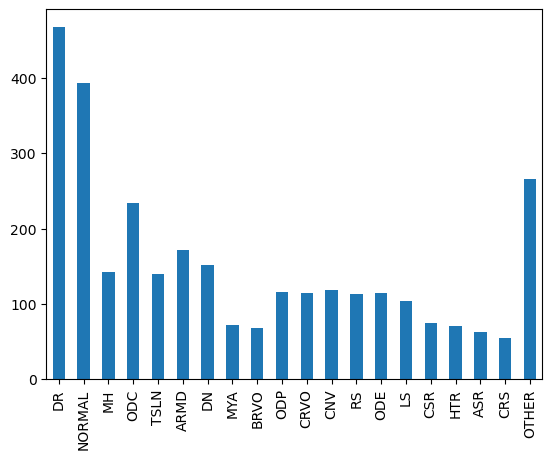

In [50]:
trainover.drop(columns="ID").sum().plot(kind="bar")

In [58]:
mldtrain=trainover.sample(1500,replace=False,axis=0,ignore_index=True,random_state=1)
# print(mldtrain["OTHER"].sum())
# mldtrain["OTHER"]=mldtrain[mldtrain[other].any(1)]["OTHER"].apply(lambda x: 1)
mldtrain

,ID,DR,NORMAL,MH,ODC,TSLN,ARMD,DN,MYA,BRVO,...,CRVO,CNV,RS,ODE,LS,CSR,HTR,ASR,CRS,OTHER
0,753,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,609,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,778,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,132,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,122,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1763,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1496,im0001,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1497,im0316,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1498,353,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: >

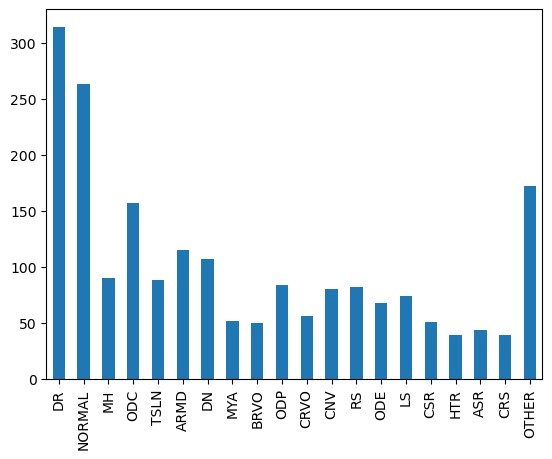

In [59]:
# mldtrain["OTHER"]=mldtrain["OTHER"].fillna(0)
# mldtrain["OTHER"]=mldtrain["OTHER"].apply(lambda x: int(x))
# mldtrain["OTHER"].sum()
mldtrain.drop(columns="ID").sum().plot(kind="bar")

In [60]:
valdf.drop(columns="ID").sum()

DR        99
NORMAL    98
MH        34
ODC       52
TSLN      31
ARMD      32
DN        32
MYA       18
BRVO      16
ODP       12
CRVO      11
CNV       12
RS        11
ODE       11
LS         9
CSR        7
HTR        7
ASR        7
CRS        6
OTHER     52
dtype: int64

In [61]:
mldval=valdf.copy()
# print(mldval["OTHER"].sum())
# other=["ODP","OTHER","HTR","ASR","CRS","CSR","LS"]
# mldval["OTHER"]=mldval[mldval[other].any(1)]["OTHER"].apply(lambda x: 1)
mldval

,ID,DR,NORMAL,MH,ODC,TSLN,ARMD,DN,MYA,BRVO,...,CRVO,CNV,RS,ODE,LS,CSR,HTR,ASR,CRS,OTHER
0,aria_c_28_19,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,aria_c_36_4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,aria_c_40_b_14,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,aria_c_23_23,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,aria_c_43_1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,im0373,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
440,im0377,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
441,im0397,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
442,im0399,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


<Axes: >

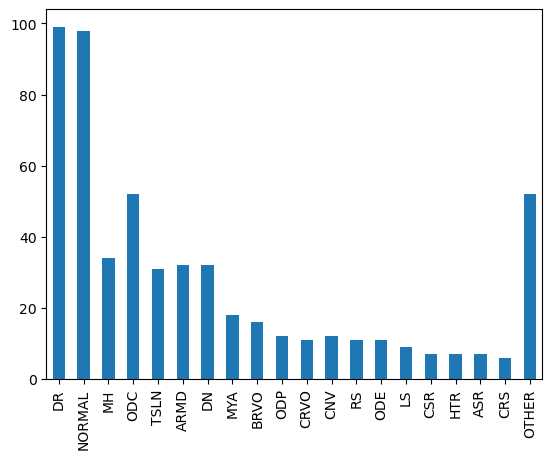

In [62]:
mldval.drop(columns="ID").sum().plot(kind="bar")

In [63]:
# mldval["OTHER"]=mldval["OTHER"].fillna(0)
# mldval["OTHER"]=mldval["OTHER"].apply(lambda x: int(x))

# mldval["OTHER"].sum()

other

In [64]:
# mldtrain.drop(columns=other,inplace=True)
# mldval.drop(columns=other,inplace=True)

In [65]:
mldtrain

,ID,DR,NORMAL,MH,ODC,TSLN,ARMD,DN,MYA,BRVO,...,CRVO,CNV,RS,ODE,LS,CSR,HTR,ASR,CRS,OTHER
0,753,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,609,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,778,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,132,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,122,1,0,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1763,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1496,im0001,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1497,im0316,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1498,353,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
mldval

,ID,DR,NORMAL,MH,ODC,TSLN,ARMD,DN,MYA,BRVO,...,CRVO,CNV,RS,ODE,LS,CSR,HTR,ASR,CRS,OTHER
0,aria_c_28_19,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,aria_c_36_4,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,aria_c_40_b_14,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,aria_c_23_23,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,aria_c_43_1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,im0373,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
440,im0377,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
441,im0397,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
442,im0399,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [67]:
! git clone https://github.com/Alibaba-MIIL/ML_Decoder.git

fatal: destination path 'ML_Decoder' already exists and is not an empty directory.


In [ ]:
!mv /kaggle/working/ML_Decoder/* /kaggle/working/

In [ ]:
!dir

In [ ]:
!mkdir /kaggle/working/model

In [68]:
import os
import argparse

import torch
import torch.nn.parallel
import torch.optim
import torch.utils.data.distributed
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from src_files.helper_functions.helper_functions import mAP, CocoDetection, CutoutPIL, ModelEma, \
    add_weight_decay
from src_files.models import create_model
from src_files.loss_functions.losses import AsymmetricLoss
from randaugment import RandAugment
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
from torchvision import transforms

batch_size=16
# train_ds=train_data=val_ds=val_data=test_ds=test_data="null"
# setdata(1)
def mldata(args,i=1,x=None,j=None):
    global train_ds,train_data,val_ds,val_data,test_ds,test_data,batch_size
    train_ds=Df_to_Dataset(mldtrain,"/kaggle/input/rumed-data/MuReD/Data/",i,j, Transform=transforms.Compose([transforms.Resize((args.image_size, args.image_size)),CutoutPIL(cutout_factor=0.5),augmentate(),transforms.ToTensor()]))
    val_ds=Df_to_Dataset(mldval,"/kaggle/input/rumed-data/MuReD/Data/",i,j, Transform=transforms.Compose([transforms.Resize((args.image_size, args.image_size)),transforms.ToTensor()]))



parser = argparse.ArgumentParser(description='PyTorch MS_COCO Training')
parser.add_argument('--data', type=str, default='/kaggle/input/rumed-data/MuReD')
parser.add_argument('--save_name', type=str, default='bestmodel1.cptk')
parser.add_argument('--lr', default=1e-4, type=float)
parser.add_argument('--model-name', default='tresnet_xl')
parser.add_argument('--model-path', default='https://miil-public-eu.oss-eu-central-1.aliyuncs.com/model-zoo/ML_Decoder/tresnet_l_pretrain_ml_decoder.pth', type=str)
parser.add_argument('--num-classes', default=20)
parser.add_argument('-j', '--workers', default=2, type=int, metavar='N',
                    help='number of data loading workers')
parser.add_argument('--image-size', default=512, type=int,
                    metavar='N', help='input image size (default: 448)')
parser.add_argument('--batch-size', default=batch_size, type=int,
                    metavar='N', help='mini-batch size')

# ML-Decoder
parser.add_argument('--use-ml-decoder', default=1, type=int)
parser.add_argument('--num-of-groups', default=-1, type=int)  # full-decoding
parser.add_argument('--decoder-embedding', default=768, type=int)
parser.add_argument('--zsl', default=0, type=int)

def main():
    args,unkown = parser.parse_known_args()
    # Setup model
    print('creating model {}...'.format(args.model_name))
    model = create_model(args).cuda()

    # local_rank = torch.distributed.get_rank()
    # torch.cuda.set_device(0)
    model = torch.nn.DataParallel(model)

    print('done')
    mldata(args)
    # COCO Data loading
    instances_path_val = os.path.join(args.data, 'annotations/instances_val2014.json')
    instances_path_train = os.path.join(args.data, 'annotations/instances_train2014.json')
    #data_path_val = args.data
    #data_path_train = args.data
    data_path_val = f'{args.data}/val2014'  # args.data
    data_path_train = f'{args.data}/train2014'  # args.data
    val_dataset = val_ds #CocoDetection(data_path_val,
#                                 instances_path_val,
#                                 transforms.Compose([
#                                     transforms.Resize((args.image_size, args.image_size)),
#                                     transforms.ToTensor(),
#                                     # normalize, # no need, toTensor does normalization
#                                 ]))
    train_dataset = train_ds #CocoDetection(data_path_train,
#                                   instances_path_train,
#                                   transforms.Compose([
#                                       transforms.Resize((args.image_size, args.image_size)),
#                                       CutoutPIL(cutout_factor=0.5),
#                                       RandAugment(),
#                                       transforms.ToTensor(),
#                                       # normalize,
#                                   ]))
    print("len(val_dataset)): ", len(val_dataset))
    print("len(train_dataset)): ", len(train_dataset))

    # Pytorch Data loader
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=True,
        num_workers = args.workers, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=args.batch_size, shuffle=False,
        num_workers = args.workers, pin_memory=False)

    # Actuall Training
    train_multi_label_coco(model, train_loader, val_loader, args.lr)


def train_multi_label_coco(model, train_loader, val_loader, lr):
    ema = ModelEma(model, 0.9997)  # 0.9997^641=0.82

    # set optimizer
    Epochs = 35
    weight_decay = 1e-4
    criterion = AsymmetricLoss(gamma_neg=4, gamma_pos=0, clip=0.05, disable_torch_grad_focal_loss=True)
#     criterion= nn.BCEWithLogitsLoss()
    parameters = add_weight_decay(model, weight_decay)
    optimizer = torch.optim.Adam(params=parameters, lr=lr, weight_decay=0)  # true wd, filter_bias_and_bn
    steps_per_epoch = len(train_loader)
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=steps_per_epoch, epochs=Epochs,
                                        pct_start=0.2)

    highest_mAP = 0
    trainInfoList = []
    scaler = GradScaler()
    for epoch in range(Epochs):
        for i, (inputData, target) in enumerate(train_loader):
            inputData = inputData.cuda()
            target = target.cuda()
#             target = target.max(dim=1)[0]
            with autocast():  # mixed precision
                output = model(inputData).float()  # sigmoid will be done in loss !
            loss = criterion(output, target)
            model.zero_grad()

            scaler.scale(loss).backward()
            # loss.backward()

            scaler.step(optimizer)
            scaler.update()
            # optimizer.step()

            scheduler.step()

            ema.update(model)
            # store information
            if i % 100 == 0:
                trainInfoList.append([epoch, i, loss.item()])
                print('Epoch [{}/{}], Step [{}/{}], LR {:.1e}, Loss: {:.1f}'
                      .format(epoch, Epochs, str(i).zfill(3), str(steps_per_epoch).zfill(3),
                              scheduler.get_last_lr()[0], \
                              loss.item()))

        try:
            torch.save(model.state_dict(), os.path.join(
                'models/', 'model-{}-{}.ckpt'.format(epoch + 1, i + 1)))
        except:
            pass

        model.eval()

        mAP_score = validate_multi(val_loader, model, ema)
        model.train()
        if mAP_score > highest_mAP:
            highest_mAP = mAP_score
            try:
                torch.save(model,
                    '/kaggle/working/model/14model.pth')
            except:
                print('error')
                pass
        print('current_mAP = {:.4f}, highest_mAP = {:.4f}\n'.format(mAP_score, highest_mAP))
    

def validate_multi(val_loader, model, ema_model):
    print("starting validation")
    Sig = torch.nn.Sigmoid()
    preds_regular = []
    preds_ema = []
    targets = []
    for i, (input, target) in enumerate(val_loader):
        target = target
#         target = target.max(dim=1)[0]
        # compute output
        with torch.no_grad():
            with autocast():
                output_regular = Sig(model(input.cuda())).cpu()
                output_ema = Sig(ema_model.module(input.cuda())).cpu()

        # for mAP calculation
        preds_regular.append(output_regular.cpu().detach())
        preds_ema.append(output_ema.cpu().detach())
        targets.append(target.cpu().detach())

    ts_map,ts_f1,ts_auc,ts_ms=Metrics(preds_regular, targets)
    mAP_score_regular=mAP(torch.cat(targets).numpy(), torch.cat(preds_regular).numpy())
    mAP_score_ema = mAP(torch.cat(targets).numpy(), torch.cat(preds_ema).numpy())
    print(' \n==>> Test set: mAP: ({:.5f})  AUC: ({:.5f})  F1:({:.5f}) ModelScore:({:.5f})\n'.format(
                ts_map,ts_auc,ts_f1,ts_ms))
    print("mAP score regular {:.2f}, mAP score EMA {:.2f}".format(mAP_score_regular, mAP_score_ema))
    return ts_ms #max(mAP_score_regular, mAP_score_ema)


if __name__ == '__main__':
    main()
# !ipykernel_launcher.py --data"/kaggle/input/rumed-data/MuReD/"

creating model tresnet_xl...
downloading pretrain model...
done
done
len(val_dataset)):  444
len(train_dataset)):  1500


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [0/35], Step [000/094], LR 4.0e-06, Loss: 138.2
starting validation
(444, 20) (444, 20)
 
==>> Test set: mAP: (0.06273)  AUC: (0.50000)  F1:(0.08468) ModelScore:(0.28136)

mAP score regular 11.57, mAP score EMA 6.84
current_mAP = 0.2814, highest_mAP = 0.2814

Epoch [1/35], Step [000/094], LR 8.9e-06, Loss: 27.0
starting validation
(444, 20) (444, 20)
 
==>> Test set: mAP: (0.08893)  AUC: (0.61494)  F1:(0.14931) ModelScore:(0.35193)

mAP score regular 27.52, mAP score EMA 6.89
current_mAP = 0.3519, highest_mAP = 0.3519

Epoch [2/35], Step [000/094], LR 2.2e-05, Loss: 28.2
starting validation
(444, 20) (444, 20)
 
==>> Test set: mAP: (0.13590)  AUC: (0.76122)  F1:(0.23914) ModelScore:(0.44856)

mAP score regular 37.10, mAP score EMA 7.02
current_mAP = 0.4486, highest_mAP = 0.4486

Epoch [3/35], Step [000/094], LR 4.2e-05, Loss: 25.9
starting validation
(444, 20) (444, 20)
 
==>> Test set: mAP: (0.19846)  AUC: (0.76417)  F1:(0.33869) ModelScore:(0.48132)

mAP score regular 47.06, mA

In [ ]:
# def binmetrics(df,model):
#     data=torch.utils.data.DataLoader(
#         df, batch_size=16, shuffle=False,
#         num_workers = 2, pin_memory=False)
#     model.eval()
#     preds=[]
#     label=[]
#     with torch.no_grad():
#         for img,lbl in data:
#             model=model.cuda()
#             img=img.to("cuda:0")
#             preds.append(F.sigmoid(model(img)))
#             label.append(lbl)
    
#     print("Lable\t\tPrec\t\tRecall\t\tF1\t\tAUC")
#     preds=np.round(torch.cat(preds,dim=0).detach().cpu().numpy())
#     label=np.asarray(torch.cat(label,dim=0).detach().cpu().numpy())
#     for i,j in enumerate(df.data.drop(columns="ID").columns):
#         print("{}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}\t\t{:.4f}".format(j,precision_score(label[:][i],preds[:][i]), recall_score(label[:][i],preds[:][i]),f1_score(label[:][i],preds[:][i]),roc_auc_score(label[:][i],preds[:][i])))
            

In [168]:
binmetrics(val_ds,torch.load('/kaggle/working/model/14model.pth').module)

Lable		Prec		Recall		F1		AUC
DR		0.0000		0.0000		0.0000		0.4737
NORMAL		0.0000		0.0000		0.0000		0.5000
MH		1.0000		1.0000		1.0000		1.0000
ODC		0.0000		0.0000		0.0000		0.4474
TSLN		1.0000		1.0000		1.0000		1.0000
ARMD		1.0000		1.0000		1.0000		1.0000
DN		1.0000		1.0000		1.0000		1.0000
MYA		1.0000		1.0000		1.0000		1.0000
BRVO		1.0000		1.0000		1.0000		1.0000
ODP		1.0000		1.0000		1.0000		1.0000
CRVO		1.0000		1.0000		1.0000		1.0000
CNV		0.3333		1.0000		0.5000		0.9474
RS		1.0000		1.0000		1.0000		1.0000
ODE		1.0000		1.0000		1.0000		1.0000
LS		0.0000		0.0000		0.0000		0.4737
CSR		0.0000		0.0000		0.0000		0.4737
HTR		0.5000		1.0000		0.6667		0.9737
ASR		0.5000		1.0000		0.6667		0.9737
CRS		1.0000		1.0000		1.0000		1.0000
OTHER		0.5000		1.0000		0.6667		0.9444

 ML_F1:(0.711) ML_mAP:(0.686) ML_AUC:(0.879) ML_Score:(0.783) Bin_F1:(0.000) Bin_mAP:(0.050) Bin_AUC:(0.500) ModelScore:(0.641)


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## ML-Decoder for other list

In [ ]:
# other

In [ ]:
# other+=["RS"]

In [ ]:
# other.append("OTHER")
# # other

In [ ]:
# mldtrain2=traindf[traindf[other].any(1)]
# mldtrain2.sum()

# bin2=set(traindf.drop(columns="ID").columns).difference(other)
# bin2

# mldtrain2["GROUP1"]=0
# mldtrain2["GROUP1"]=mldtrain2[mldtrain2[bin2].any(1)]["GROUP1"].apply(lambda x: 1)

# mldtrain2["GROUP1"]=mldtrain2["GROUP1"].fillna(0)
# mldtrain2["GROUP1"]=mldtrain2["GROUP1"].apply(lambda x: int(x))
# mldtrain2["GROUP1"].sum()

# mldval2=valdf[valdf[other].any(1)]
# mldval2.sum()

# mldval2["GROUP1"]=0
# mldval2["GROUP1"]=mldval2[mldval2[bin2].any(1)]["GROUP1"].apply(lambda x: 1)
# mldval2["GROUP1"]=mldval2["GROUP1"].fillna(0)
# mldval2["GROUP1"]=mldval2["GROUP1"].apply(lambda x: int(x))
# mldval2["GROUP1"].sum()

In [ ]:
# mldval2.drop(columns=bin2, inplace=True)
# mldtrain2.drop(columns=bin2, inplace=True)

In [159]:
mldtrain2=traindf.copy()

In [227]:
mldtrain2

,ID,DR,NORMAL,MH,ODC,TSLN,ARMD,DN,MYA,BRVO,...,CRVO,CNV,RS,ODE,LS,CSR,HTR,ASR,CRS,OTHER
0,aria_c_25_1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,aria_c_7_2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,aria_c_38_2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,aria_c_2_8,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,aria_c_26_15,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759,im0395,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1760,im0396,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1761,im0398,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1762,im0400,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [228]:
import os
import argparse

import torch
import torch.nn.parallel
import torch.optim
import torch.utils.data.distributed
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from src_files.helper_functions.helper_functions import mAP, CocoDetection, CutoutPIL, ModelEma, \
    add_weight_decay
from src_files.models import create_model
from src_files.loss_functions.losses import AsymmetricLoss
from randaugment import RandAugment
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
from torchvision import transforms

batch_size=16
# train_ds=train_data=val_ds=val_data=test_ds=test_data="null"
# setdata(1)
def mldata2(args,i=1,x=None,j=None):
    global train_ds,train_data,val_ds,val_data,test_ds,test_data,batch_size
    train_ds=Df_to_Dataset(mldtrain2,"/kaggle/input/rumed-data/MuReD/Data/",i,j, Transform=transforms.Compose([transforms.Resize((args.image_size, args.image_size)),CutoutPIL(cutout_factor=0.5),augmentate(),transforms.ToTensor()]))
    val_ds=Df_to_Dataset(valdf,"/kaggle/input/rumed-data/MuReD/Data/",i,j, Transform=transforms.Compose([transforms.Resize((args.image_size, args.image_size)),transforms.ToTensor()]))



parser = argparse.ArgumentParser(description='PyTorch MS_COCO Training')
parser.add_argument('--data', type=str, default='/kaggle/input/rumed-data/MuReD')
parser.add_argument('--save_name', type=str, default='bestmodel2.cptk')
parser.add_argument('--lr', default=1e-4, type=float)
parser.add_argument('--model-name', default='tresnet_l')
parser.add_argument('--model-path', default='https://miil-public-eu.oss-eu-central-1.aliyuncs.com/model-zoo/ML_Decoder/tresnet_l_pretrain_ml_decoder.pth', type=str)
parser.add_argument('--num-classes', default=20)
parser.add_argument('-j', '--workers', default=2, type=int, metavar='N',
                    help='number of data loading workers')
parser.add_argument('--image-size', default=512, type=int,
                    metavar='N', help='input image size (default: 448)')
parser.add_argument('--batch-size', default=batch_size, type=int,
                    metavar='N', help='mini-batch size')

# ML-Decoder
parser.add_argument('--use-ml-decoder', default=1, type=int)
parser.add_argument('--num-of-groups', default=-1, type=int)  # full-decoding
parser.add_argument('--decoder-embedding', default=768, type=int)
parser.add_argument('--zsl', default=0, type=int)

def main():
    args,unkown = parser.parse_known_args()
    # Setup model
    print('creating model {}...'.format(args.model_name))
    model = create_model(args).cuda()

    # local_rank = torch.distributed.get_rank()
    # torch.cuda.set_device(0)
    model = torch.nn.DataParallel(model)

    print('done')
    mldata2(args)
    # COCO Data loading
    instances_path_val = os.path.join(args.data, 'annotations/instances_val2014.json')
    instances_path_train = os.path.join(args.data, 'annotations/instances_train2014.json')
    #data_path_val = args.data
    #data_path_train = args.data
    data_path_val = f'{args.data}/val2014'  # args.data
    data_path_train = f'{args.data}/train2014'  # args.data
    val_dataset = val_ds #CocoDetection(data_path_val,
#                                 instances_path_val,
#                                 transforms.Compose([
#                                     transforms.Resize((args.image_size, args.image_size)),
#                                     transforms.ToTensor(),
#                                     # normalize, # no need, toTensor does normalization
#                                 ]))
    train_dataset = train_ds #CocoDetection(data_path_train,
#                                   instances_path_train,
#                                   transforms.Compose([
#                                       transforms.Resize((args.image_size, args.image_size)),
#                                       CutoutPIL(cutout_factor=0.5),
#                                       RandAugment(),
#                                       transforms.ToTensor(),
#                                       # normalize,
#                                   ]))
    print("len(val_dataset)): ", len(val_dataset))
    print("len(train_dataset)): ", len(train_dataset))

    # Pytorch Data loader
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=True,
        num_workers = args.workers, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=args.batch_size, shuffle=False,
        num_workers = args.workers, pin_memory=False)

    # Actuall Training
    train_multi_label_coco(model, train_loader, val_loader, args.lr)


def train_multi_label_coco(model, train_loader, val_loader, lr):
    ema = ModelEma(model, 0.9997)  # 0.9997^641=0.82

    # set optimizer
    Epochs = 45
    weight_decay = 1e-4
    criterion = AsymmetricLoss(gamma_neg=4, gamma_pos=0, clip=0.05, disable_torch_grad_focal_loss=True)
#     criterion= nn.BCEWithLogitsLoss()
    parameters = add_weight_decay(model, weight_decay)
    optimizer = torch.optim.Adam(params=parameters, lr=lr, weight_decay=0)  # true wd, filter_bias_and_bn
    steps_per_epoch = len(train_loader)
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=steps_per_epoch, epochs=Epochs,
                                        pct_start=0.2)

    highest_mAP = 0
    trainInfoList = []
    scaler = GradScaler()
    for epoch in range(Epochs):
        for i, (inputData, target) in enumerate(train_loader):
            inputData = inputData.cuda()
            target = target.cuda()
#             target = target.max(dim=1)[0]
            with autocast():  # mixed precision
                output = model(inputData).float()  # sigmoid will be done in loss !
            loss = criterion(output, target)
            model.zero_grad()

            scaler.scale(loss).backward()
            # loss.backward()

            scaler.step(optimizer)
            scaler.update()
            # optimizer.step()

            scheduler.step()

            ema.update(model)
            # store information
            if i % 10 == 0:
                trainInfoList.append([epoch, i, loss.item()])
                print('Epoch [{}/{}], Step [{}/{}], LR {:.1e}, Loss: {:.1f}'
                      .format(epoch, Epochs, str(i).zfill(3), str(steps_per_epoch).zfill(3),
                              scheduler.get_last_lr()[0], \
                              loss.item()))

        try:
            torch.save(model.state_dict(), os.path.join(
                'models/', 'model-{}-{}.ckpt'.format(epoch + 1, i + 1)))
        except:
#             print("error to save")
            pass

        model.eval()

        mAP_score = validate_multi(val_loader, model, ema)
        model.train()
        if mAP_score > highest_mAP:
            highest_mAP = mAP_score
            try:
                torch.save(model,"/kaggle/working/model/nosampling_model.pth")
                print("-------done------")
            except:
                print("error")
                pass
        print('current_mAP = {:.4f}, highest_mAP = {:.4f}\n'.format(mAP_score, highest_mAP))


def validate_multi(val_loader, model, ema_model):
    print("starting validation")
    Sig = torch.nn.Sigmoid()
    preds_regular = []
    preds_ema = []
    targets = []
    for i, (input, target) in enumerate(val_loader):
        target = target
#         target = target.max(dim=1)[0]
        # compute output
        with torch.no_grad():
            with autocast():
                output_regular = Sig(model(input.cuda())).cpu()
                output_ema = Sig(ema_model.module(input.cuda())).cpu()

        # for mAP calculation
        preds_regular.append(output_regular.cpu().detach())
        preds_ema.append(output_ema.cpu().detach())
        targets.append(target.cpu().detach())

    ts_map,ts_f1,ts_auc,ts_ms=Metrics(preds_regular, targets)
    mAP_score_regular=mAP(torch.cat(targets).numpy(), torch.cat(preds_regular).numpy())
    mAP_score_ema = mAP(torch.cat(targets).numpy(), torch.cat(preds_ema).numpy())
    print(' \n==>> Test set: mAP: ({:.5f})  AUC: ({:.5f})  F1:({:.5f}) ModelScore:({:.5f})\n'.format(
                ts_map,ts_auc,ts_f1,ts_ms))
    print("mAP score regular {:.2f}, mAP score EMA {:.2f}".format(mAP_score_regular, mAP_score_ema))
    return ts_ms#max(mAP_score_regular, mAP_score_ema)


if __name__ == '__main__':
    main()
# !ipykernel_launcher.py --data"/kaggle/input/rumed-data/MuReD/"

creating model tresnet_l...
done
len(val_dataset)):  444
len(train_dataset)):  1763


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [0/45], Step [000/111], LR 4.0e-06, Loss: 147.1
Epoch [0/45], Step [010/111], LR 4.0e-06, Loss: 114.9
Epoch [0/45], Step [020/111], LR 4.1e-06, Loss: 73.9
Epoch [0/45], Step [030/111], LR 4.2e-06, Loss: 48.1
Epoch [0/45], Step [040/111], LR 4.4e-06, Loss: 31.0
Epoch [0/45], Step [050/111], LR 4.6e-06, Loss: 30.5
Epoch [0/45], Step [060/111], LR 4.9e-06, Loss: 26.6
Epoch [0/45], Step [070/111], LR 5.2e-06, Loss: 23.9
Epoch [0/45], Step [080/111], LR 5.6e-06, Loss: 26.1
Epoch [0/45], Step [090/111], LR 6.0e-06, Loss: 22.1
Epoch [0/45], Step [100/111], LR 6.4e-06, Loss: 22.1
Epoch [0/45], Step [110/111], LR 6.9e-06, Loss: 5.3
starting validation
(444, 20) (444, 20)
 
==>> Test set: mAP: (0.06273)  AUC: (0.50000)  F1:(0.08437) ModelScore:(0.28136)

mAP score regular 14.83, mAP score EMA 8.06
-------done------
current_mAP = 0.2814, highest_mAP = 0.2814

Epoch [1/45], Step [000/111], LR 7.0e-06, Loss: 22.9
Epoch [1/45], Step [010/111], LR 7.5e-06, Loss: 23.0
Epoch [1/45], Step [020/111

In [165]:
binmetrics(val_ds,torch.load("/kaggle/working/model/nosampling_model.pth").module)

Lable		Prec		Recall		F1		AUC
DR		0.5000		1.0000		0.6667		0.9737
NORMAL		1.0000		1.0000		1.0000		1.0000
MH		1.0000		1.0000		1.0000		1.0000
ODC		0.5000		1.0000		0.6667		0.9737
TSLN		1.0000		1.0000		1.0000		1.0000
ARMD		1.0000		1.0000		1.0000		1.0000
DN		0.5000		1.0000		0.6667		0.9737
MYA		1.0000		1.0000		1.0000		1.0000
BRVO		1.0000		1.0000		1.0000		1.0000
ODP		1.0000		1.0000		1.0000		1.0000
CRVO		1.0000		1.0000		1.0000		1.0000
CNV		0.3333		1.0000		0.5000		0.9474
RS		0.5000		1.0000		0.6667		0.9737
ODE		0.3333		1.0000		0.5000		0.9474
LS		0.0000		0.0000		0.0000		0.4737
CSR		0.0000		0.0000		0.0000		0.4737
HTR		0.0000		0.0000		0.0000		0.4737
ASR		0.0000		0.0000		0.0000		0.4737
CRS		1.0000		1.0000		1.0000		1.0000
OTHER		1.0000		1.0000		1.0000		1.0000

 ML_F1:(0.667) ML_mAP:(0.625) ML_AUC:(0.878) ML_Score:(0.751) Bin_F1:(1.000) Bin_mAP:(1.000) Bin_AUC:(1.000) ModelScore:(0.876)


In [ ]:
# bin3=["NORMAL","DR","OTHER","ODC","ARMD"]
# mldtrain3=traindf[traindf[bin3].any(1)].copy()
# ex3=set(mldtrain3.drop(columns="ID").columns).difference(bin3)
# mldtrain3["GROUP2"]=0
# mldtrain3["GROUP2"]=mldtrain3[mldtrain3[ex3].any(1)]["GROUP2"].apply(lambda x:1)
# mldtrain3["GROUP2"]=mldtrain3["GROUP2"].fillna(0)
# mldtrain3["GROUP2"]=mldtrain3["GROUP2"].apply(lambda x: int(x))
# mldtrain3

In [ ]:
# mldval3=valdf[valdf[bin3].any(1)].copy()
# mldval3["GROUP2"]=0
# mldval3["GROUP2"]=mldval3[mldval3[ex3].any(1)]["GROUP2"].apply(lambda x:1)
# mldval3["GROUP2"]=mldval3["GROUP2"].fillna(0)
# mldval3["GROUP2"]=mldval3["GROUP2"].apply(lambda x: int(x))
# mldval3

In [135]:
up=xt[xt<xt.mean()*0.5].index.to_list()
traindf[traindf[up].any(1)]

/tmp/ipykernel_28/477731683.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  traindf[traindf[up].any(1)]


,ID,DR,NORMAL,MH,ODC,TSLN,ARMD,DN,MYA,BRVO,...,CRVO,CNV,RS,ODE,LS,CSR,HTR,ASR,CRS,OTHER
125,26,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
128,30,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
129,31,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
148,53,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
149,55,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1757,im0384,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1758,im0385,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1760,im0396,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1761,im0398,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [140]:
query=traindf[traindf[up].any(1)].ID.to_list()
temp=traindf.query("ID not in @query")

/tmp/ipykernel_28/3852200620.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  query=traindf[traindf[up].any(1)].ID.to_list()


In [141]:
temp

,ID,DR,NORMAL,MH,ODC,TSLN,ARMD,DN,MYA,BRVO,...,CRVO,CNV,RS,ODE,LS,CSR,HTR,ASR,CRS,OTHER
0,aria_c_25_1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,aria_c_7_2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,aria_c_38_2,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,aria_c_2_8,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,aria_c_26_15,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1742,im0360,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1743,im0362,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1744,im0363,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1759,im0395,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [171]:
# mldtrain3.drop(columns=ex3, inplace=True)
# mldval3.drop(columns=ex3, inplace=True)
mldtrain3=pd.concat([temp,traindf[traindf[up].any(1)].sample(frac=1.6,replace=True,axis=0,ignore_index=True,random_state=42)],ignore_index=True).sample(1800,ignore_index=True,random_state=42)

/tmp/ipykernel_28/754027928.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  mldtrain3=pd.concat([temp,traindf[traindf[up].any(1)].sample(frac=1.6,replace=True,axis=0,ignore_index=True,random_state=42)],ignore_index=True).sample(1800,ignore_index=True,random_state=42)


<Axes: >

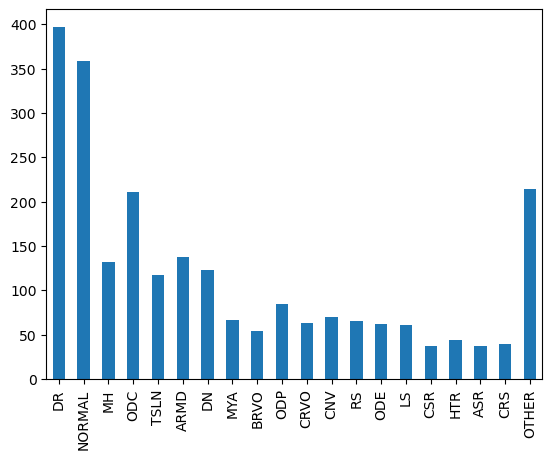

In [172]:
mldtrain3.drop(columns="ID").sum().plot(kind="bar")

In [173]:
# xt3=mldtrain3.drop(columns="ID").sum()
# up3=xt3[xt3<xt3.mean()*0.5].index.to_list()
# up3

In [174]:
# temp=traindf[traindf[up3].any(1)].sample(len(up3)*70,axis=0,random_state=42,ignore_index=True)

In [175]:
# temp.drop(columns="ID").sum().plot(kind="bar")

In [176]:
# mldtrain3=pd.concat([mldtrain3,temp],ignore_index=True)

In [177]:
# mldtrain3.drop(columns="ID").sum().plot(kind="bar")

In [178]:
import os
import argparse

import torch
import torch.nn.parallel
import torch.optim
import torch.utils.data.distributed
import torchvision.transforms as transforms
from torch.optim import lr_scheduler
from src_files.helper_functions.helper_functions import mAP, CocoDetection, CutoutPIL, ModelEma, \
    add_weight_decay
from src_files.models import create_model
from src_files.loss_functions.losses import AsymmetricLoss
from randaugment import RandAugment
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
from torchvision import transforms

batch_size=16
# train_ds=train_data=val_ds=val_data=test_ds=test_data="null"
# setdata(1)
def mldata3(args,i=1,x=None,j=None):
    global train_ds,train_data,val_ds,val_data,test_ds,test_data,batch_size
    train_ds=Df_to_Dataset(mldtrain3,"/kaggle/input/rumed-data/MuReD/Data/",i,j, Transform=transforms.Compose([transforms.Resize((args.image_size, args.image_size)),CutoutPIL(cutout_factor=0.5),augmentate(0.05,0.05),transforms.ToTensor()]))
    val_ds=Df_to_Dataset(valdf,"/kaggle/input/rumed-data/MuReD/Data/",i,j, Transform=transforms.Compose([transforms.Resize((args.image_size, args.image_size)),transforms.ToTensor()]))



parser = argparse.ArgumentParser(description='PyTorch MS_COCO Training')
parser.add_argument('--data', type=str, default='/kaggle/input/rumed-data/MuReD')
parser.add_argument('--save_name', type=str, default='bestmodel2.cptk')
parser.add_argument('--lr', default=1e-4, type=float)
parser.add_argument('--model-name', default='tresnet_xl')
parser.add_argument('--model-path', default='https://miil-public-eu.oss-eu-central-1.aliyuncs.com/model-zoo/ML_Decoder/tresnet_l_pretrain_ml_decoder.pth', type=str)
parser.add_argument('--num-classes', default=20)
parser.add_argument('-j', '--workers', default=2, type=int, metavar='N',
                    help='number of data loading workers')
parser.add_argument('--image-size', default=448, type=int,
                    metavar='N', help='input image size (default: 448)')
parser.add_argument('--batch-size', default=batch_size, type=int,
                    metavar='N', help='mini-batch size')

# ML-Decoder
parser.add_argument('--use-ml-decoder', default=1, type=int)
parser.add_argument('--num-of-groups', default=-1, type=int)  # full-decoding
parser.add_argument('--decoder-embedding', default=768, type=int)
parser.add_argument('--zsl', default=0, type=int)

def main():
    args,unkown = parser.parse_known_args()
    # Setup model
    print('creating model {}...'.format(args.model_name))
    model = create_model(args).cuda()

    # local_rank = torch.distributed.get_rank()
    # torch.cuda.set_device(0)
    model = torch.nn.DataParallel(model)

    print('done')
    mldata3(args)
    # COCO Data loading
    instances_path_val = os.path.join(args.data, 'annotations/instances_val2014.json')
    instances_path_train = os.path.join(args.data, 'annotations/instances_train2014.json')
    #data_path_val = args.data
    #data_path_train = args.data
    data_path_val = f'{args.data}/val2014'  # args.data
    data_path_train = f'{args.data}/train2014'  # args.data
    val_dataset = val_ds #CocoDetection(data_path_val,
#                                 instances_path_val,
#                                 transforms.Compose([
#                                     transforms.Resize((args.image_size, args.image_size)),
#                                     transforms.ToTensor(),
#                                     # normalize, # no need, toTensor does normalization
#                                 ]))
    train_dataset = train_ds #CocoDetection(data_path_train,
#                                   instances_path_train,
#                                   transforms.Compose([
#                                       transforms.Resize((args.image_size, args.image_size)),
#                                       CutoutPIL(cutout_factor=0.5),
#                                       RandAugment(),
#                                       transforms.ToTensor(),
#                                       # normalize,
#                                   ]))
    print("len(val_dataset)): ", len(val_dataset))
    print("len(train_dataset)): ", len(train_dataset))

    # Pytorch Data loader
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.batch_size, shuffle=True,
        num_workers = args.workers, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=args.batch_size, shuffle=False,
        num_workers = args.workers, pin_memory=False)

    # Actuall Training
    train_multi_label_coco(model, train_loader, val_loader, args.lr)


def train_multi_label_coco(model, train_loader, val_loader, lr):
    ema = ModelEma(model, 0.9997)  # 0.9997^641=0.82

    # set optimizer
    Epochs = 45
    weight_decay = 1e-4
    criterion = AsymmetricLoss(gamma_neg=4, gamma_pos=0, clip=0.05, disable_torch_grad_focal_loss=True)
#     criterion= nn.BCEWithLogitsLoss()
    parameters = add_weight_decay(model, weight_decay)
    optimizer = torch.optim.Adam(params=parameters, lr=lr, weight_decay=0)  # true wd, filter_bias_and_bn
    steps_per_epoch = len(train_loader)
    scheduler = lr_scheduler.OneCycleLR(optimizer, max_lr=lr, steps_per_epoch=steps_per_epoch, epochs=Epochs,
                                        pct_start=0.2)

    highest_mAP = 0
    trainInfoList = []
    scaler = GradScaler()
    for epoch in range(Epochs):
        for i, (inputData, target) in enumerate(train_loader):
            inputData = inputData.cuda()
            target = target.cuda()
#             target = target.max(dim=1)[0]
            with autocast():  # mixed precision
                output = model(inputData).float()  # sigmoid will be done in loss !
            loss = criterion(output, target)
            model.zero_grad()

            scaler.scale(loss).backward()
            # loss.backward()

            scaler.step(optimizer)
            scaler.update()
            # optimizer.step()

            scheduler.step()

            ema.update(model)
            # store information
            if i % 40 == 0:
                trainInfoList.append([epoch, i, loss.item()])
                print('Epoch [{}/{}], Step [{}/{}], LR {:.1e}, Loss: {:.1f}'
                      .format(epoch, Epochs, str(i).zfill(3), str(steps_per_epoch).zfill(3),
                              scheduler.get_last_lr()[0], \
                              loss.item()))

        try:
            torch.save(model.state_dict(), os.path.join(
                'models/', 'model-{}-{}.ckpt'.format(epoch + 1, i + 1)))
        except:
#             print("error to save")
            pass

        model.eval()

        mAP_score = validate_multi(val_loader, model, ema)
        model.train()
        if mAP_score > highest_mAP:
            highest_mAP = mAP_score
            try:
                torch.save(model,"/kaggle/working/model/MSS_model.pth")
                print("-------done------")
            except:
                print("error")
                pass
        print('current_mAP = {:.4f}, highest_mAP = {:.4f}\n'.format(mAP_score, highest_mAP))


def validate_multi(val_loader, model, ema_model):
    print("starting validation")
    Sig = torch.nn.Sigmoid()
    preds_regular = []
    preds_ema = []
    targets = []
    for i, (input, target) in enumerate(val_loader):
        target = target
#         target = target.max(dim=1)[0]
        # compute output
        with torch.no_grad():
            with autocast():
                output_regular = Sig(model(input.cuda())).cpu()
                output_ema = Sig(ema_model.module(input.cuda())).cpu()

        # for mAP calculation
        preds_regular.append(output_regular.cpu().detach())
        preds_ema.append(output_ema.cpu().detach())
        targets.append(target.cpu().detach())

    ts_map,ts_f1,ts_auc,ts_ms=Metrics(preds_regular, targets)
    mAP_score_regular=mAP(torch.cat(targets).numpy(), torch.cat(preds_regular).numpy())
    mAP_score_ema = mAP(torch.cat(targets).numpy(), torch.cat(preds_ema).numpy())
    print(' \n==>> Test set: mAP: ({:.5f})  AUC: ({:.5f})  F1:({:.5f}) ModelScore:({:.5f})\n'.format(
                ts_map,ts_auc,ts_f1,ts_ms))
    print("mAP score regular {:.2f}, mAP score EMA {:.2f}".format(mAP_score_regular, mAP_score_ema))
    return ts_ms#max(mAP_score_regular, mAP_score_ema)


if __name__ == '__main__':
    main()
# !ipykernel_launcher.py --data"/kaggle/input/rumed-data/MuReD/"

creating model tresnet_xl...
downloading pretrain model...
done
done
len(val_dataset)):  444
len(train_dataset)):  1800


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [0/45], Step [000/113], LR 4.0e-06, Loss: 80.2
Epoch [0/45], Step [040/113], LR 4.4e-06, Loss: 24.1
Epoch [0/45], Step [080/113], LR 5.5e-06, Loss: 25.0
starting validation
(444, 20) (444, 20)
 
==>> Test set: mAP: (0.06268)  AUC: (0.49896)  F1:(0.08669) ModelScore:(0.28082)

mAP score regular 14.27, mAP score EMA 8.27
-------done------
current_mAP = 0.2808, highest_mAP = 0.2808

Epoch [1/45], Step [000/113], LR 7.0e-06, Loss: 22.9
Epoch [1/45], Step [040/113], LR 9.3e-06, Loss: 25.4
Epoch [1/45], Step [080/113], LR 1.2e-05, Loss: 25.3
starting validation
(444, 20) (444, 20)
 
==>> Test set: mAP: (0.07204)  AUC: (0.53119)  F1:(0.12104) ModelScore:(0.30162)

mAP score regular 24.12, mAP score EMA 8.46
-------done------
current_mAP = 0.3016, highest_mAP = 0.3016

Epoch [2/45], Step [000/113], LR 1.5e-05, Loss: 25.7
Epoch [2/45], Step [040/113], LR 1.9e-05, Loss: 24.7
Epoch [2/45], Step [080/113], LR 2.4e-05, Loss: 20.7
starting validation
(444, 20) (444, 20)
 
==>> Test set: mAP: (

In [186]:
binmetrics(val_ds,torch.load("/kaggle/working/model/MSS_model.pth"))

Lable		Prec		Recall		F1		AUC
DR		0.5000		1.0000		0.6667		0.9737
NORMAL		0.5000		1.0000		0.6667		0.9737
MH		0.5000		1.0000		0.6667		0.9737
ODC		0.0000		0.0000		0.0000		0.4737
TSLN		1.0000		1.0000		1.0000		1.0000
ARMD		1.0000		1.0000		1.0000		1.0000
DN		1.0000		1.0000		1.0000		1.0000
MYA		0.5000		1.0000		0.6667		0.9737
BRVO		1.0000		1.0000		1.0000		1.0000
ODP		1.0000		1.0000		1.0000		1.0000
CRVO		1.0000		1.0000		1.0000		1.0000
CNV		0.5000		1.0000		0.6667		0.9737
RS		0.5000		1.0000		0.6667		0.9737
ODE		0.3333		1.0000		0.5000		0.9474
LS		0.5000		1.0000		0.6667		0.9737
CSR		0.0000		0.0000		0.0000		0.4737
HTR		0.0000		0.0000		0.0000		0.4474
ASR		0.0000		0.0000		0.0000		0.4737
CRS		1.0000		1.0000		1.0000		1.0000
OTHER		1.0000		1.0000		1.0000		1.0000

 ML_F1:(0.658) ML_mAP:(0.607) ML_AUC:(0.877) ML_Score:(0.742) Bin_F1:(0.667) Bin_mAP:(0.500) Bin_AUC:(0.974) ModelScore:(0.858)


# 9. Ensemble ANN Model <a class="anchor"  id="ensemble"></a>

In [200]:
class Ensemble_model(nn.Module):
    def __init__(self,models,dropout=0.1):
        super(Ensemble_model,self).__init__()
        self.models=[torch.load(model).module.cuda() for model in models]
        for model in self.models:
            for param in model.parameters():
                param.requires_grad = False
        self.dropout=nn.Dropout(p=dropout)
        self.Linear1=nn.Linear(60,30)
        self.relu=nn.ReLU()
        self.Linear2=nn.Linear(28,25)
        self.output=nn.Linear(30,20)
        
    def forward(self,x):
        xt=[]
        for i in self.models:
            xt.append(i(x.cuda()))
        x=torch.cat(xt,dim=1)
        x=self.Linear1(x)
#         x=self.relu(self.Linear2(x))
#         x=self.dropout(x)
        out=self.output(x)
        return out

In [201]:
modelspath=["/kaggle/working/model/14model.pth","/kaggle/working/model/nosampling_model.pth","/kaggle/working/model/MSS_model.pth"]
ensemble=Ensemble_model(modelspath)

In [202]:
setdata(1)

In [204]:
final_model,history=Tranfertrainloop_multilabel({"lr":2.5e-3},20,20,modelin=ensemble)

(1763, 20) (1763, 20)
(444, 20) (444, 20)
Epoch 1, 
Training set: loss 31.6936293 mAP: (0.09480)  AUC: (0.58898)  F1:(0.16608) ModelScore:(0.34189) 
==>> Test set: loss 19.5340335 mAP: (0.10664)  AUC: (0.62969)  F1:(0.18587) ModelScore:(0.36817)

__
(1763, 20) (1763, 20)
(444, 20) (444, 20)
Epoch 2, 
Training set: loss 11.5016390 mAP: (0.19458)  AUC: (0.83680)  F1:(0.32714) ModelScore:(0.51569) 
==>> Test set: loss 12.6314605 mAP: (0.22836)  AUC: (0.79404)  F1:(0.38180) ModelScore:(0.51120)

__
(1763, 20) (1763, 20)
(444, 20) (444, 20)
Epoch 3, 
Training set: loss 5.1441783 mAP: (0.39204)  AUC: (0.95234)  F1:(0.55290) ModelScore:(0.67219) 
==>> Test set: loss 12.0004037 mAP: (0.33638)  AUC: (0.82371)  F1:(0.50650) ModelScore:(0.58004)

__
(1763, 20) (1763, 20)
(444, 20) (444, 20)
Epoch 4, 
Training set: loss 3.0662273 mAP: (0.54318)  AUC: (0.97398)  F1:(0.69415) ModelScore:(0.75858) 
==>> Test set: loss 12.9550756 mAP: (0.38633)  AUC: (0.83117)  F1:(0.55496) ModelScore:(0.60875)

__
(1

In [207]:
binmetrics(val_ds,final_model)
torch.save(final_model,"/kaggle/working/model/final_model.pth")

Lable		Prec		Recall		F1		AUC
DR		0.5000		1.0000		0.6667		0.9737
NORMAL		1.0000		1.0000		1.0000		1.0000
MH		1.0000		1.0000		1.0000		1.0000
ODC		1.0000		1.0000		1.0000		1.0000
TSLN		0.0000		0.0000		0.0000		0.4474
ARMD		0.5000		1.0000		0.6667		0.9737
DN		1.0000		1.0000		1.0000		1.0000
MYA		0.5000		1.0000		0.6667		0.9737
BRVO		0.5000		1.0000		0.6667		0.9737
ODP		1.0000		1.0000		1.0000		1.0000
CRVO		1.0000		1.0000		1.0000		1.0000
CNV		1.0000		1.0000		1.0000		1.0000
RS		0.0000		0.0000		0.0000		0.4737
ODE		1.0000		1.0000		1.0000		1.0000
LS		0.5000		1.0000		0.6667		0.9737
CSR		0.0000		0.0000		0.0000		0.4474
HTR		0.0000		0.0000		0.0000		0.4737
ASR		0.5000		1.0000		0.6667		0.9737
CRS		1.0000		1.0000		1.0000		1.0000
OTHER		1.0000		1.0000		1.0000		1.0000

 ML_F1:(0.684) ML_mAP:(0.642) ML_AUC:(0.878) ML_Score:(0.760) Bin_F1:(1.000) Bin_mAP:(1.000) Bin_AUC:(1.000) ModelScore:(0.880)
